<a href="https://www.kaggle.com/code/viniciusluizfranca/eda-for-player-position-fifa-22?scriptVersionId=119794160" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
def get_df(path):
    return pd.read_csv(path, low_memory=False)

In [ ]:
def get_dtypes(df):
    feat_cat = df.select_dtypes(include = object).columns
    feat_num = df.select_dtypes(exclude = object).columns
    return feat_cat, feat_num

In [ ]:
df = get_df('/kaggle/input/fifa-22-complete-player-dataset/players_22.csv')
df.head(3)

In [ ]:
f'{df.shape[0]} players and {df.shape[1]} features'

In [ ]:
# Get categorical and numerics features
feat_cat, feat_num = get_dtypes(df)
feat_cat, feat_num

In [ ]:
print(f'{feat_cat.shape[0]} categorical features\n{feat_num.shape[0]} numerical features (target "value_eur" is included)')

## Correlation between
The three financial featuers are highly correlated. In fact, the value of the clause has a perfect correlation with the player's salary

In [ ]:
fig = plt.figure(figsize = (10, 8))
sns.heatmap(df[['value_eur', 'wage_eur', 'release_clause_eur']].corr(), annot = True);

# 1: FEATURE ENGINEERING

## 1.1 Convert position from str to int

In [ ]:
POSITIONS = [  'ls' , 'st' , 'rs'  , 'lw' , 'lf'
             , 'cf' , 'rf' , 'rw'  , 'lam', 'cam'
             , 'ram', 'lm' , 'lcm' , 'cm' , 'rcm'
             , 'rm' , 'lwb', 'ldm' , 'cdm', 'rdm'
             , 'rwb', 'lb' , 'lcb' , 'cb' , 'rcb'
             , 'rb' , 'gk']

In [ ]:
def split_position_skill(position_skill):
    parts = position_skill.split('+') if '+' in position_skill else position_skill.split('-') if '-' in position_skill else position_skill.split()
    general = int(parts[0])
    variation = 0 if len(parts) == 1 else int(parts[1]) if '+' in position_skill else -int(parts[1])
    return general, variation

In [ ]:
%%timeit

# Convert str to int
for pos in POSITIONS:
    try:
        df[[pos, f'variation_{pos}']] = df[pos].apply(split_position_skill).apply(pd.Series)
        df[pos] = df[pos] + df[f'variation_{pos}']
        df.drop([f'variation_{pos}'], axis=1, inplace = True)
    except:
        break

In [ ]:
df[['short_name'] + POSITIONS].head()

## 1.2 Count and Replace player positions
If the player positions in the club is RES or SUB then his position will be replaced by the player's first position value

In [ ]:
df[['short_name', 'player_positions']].head()

In [ ]:
df['player_positions'] = df['player_positions'].str.split(',')
df['player_positions']

In [ ]:
sub_res_idx = df.loc[(df['club_position'] == 'SUB') | (df['club_position'] == 'RES')].index
sub_res_new_positions = df.loc[sub_res_idx]['player_positions'].str[0]
df.loc[sub_res_idx, 'club_position'] = sub_res_new_positions

In [ ]:
df['player_positions_count'] = df['player_positions'].str.len()

In [ ]:
df[['short_name', 'player_positions_count']].head()

## 1.3 Convert work_rate from categorical ordinal to discrete integer

In [ ]:
df['work_rate']

In [ ]:
df['work_rate'] = df['work_rate'].str.split('/')

In [ ]:
%%timeit

work_rate_def_conditions = [
    (df['work_rate'].str[0] == 'High')
    , (df['work_rate'].str[0] == 'Medium')
    , (df['work_rate'].str[0] == 'Low')
]

work_rate_ata_conditions = [
    (df['work_rate'].str[1] == 'High')
    , (df['work_rate'].str[1] == 'Medium')
    , (df['work_rate'].str[1] == 'Low')
]

work_rate_classification = [3, 2, 1]

df['work_rate_defense'] = np.select(work_rate_def_conditions, work_rate_classification, default = np.nan)
df['work_rate_attack'] = np.select(work_rate_ata_conditions, work_rate_classification, default = np.nan)

In [ ]:
df[['short_name', 'work_rate_defense', 'work_rate_attack']].head()

## 1.3 Counting player_tags and player_traits

In [ ]:
df[['short_name','player_tags', 'player_traits']]

In [ ]:
df['player_tags'] = df['player_tags'].str.split('#').str.len()
df['player_tags'].fillna(0, inplace = True)

In [ ]:
df['player_traits'] = df['player_traits'].str.split(',').str.len()
df['player_traits'].fillna(0, inplace = True)

In [ ]:
df[['short_name','player_tags', 'player_traits']]

## 1.4 Difference between overall and potential

In [ ]:
df['potential_difference'] = df['potential'] - df['overall']
df[['short_name', 'potential_difference']]

## 1.5 Remove unused features

In [ ]:
# Remove columns
remove_columns_to_X = [  'work_rate', 'club_contract_valid_until', 'club_flag_url'
                       , 'long_name', 'nationality_id', 'release_clause_eur', 'club_team_id'
                       , 'player_url', 'player_positions', 'club_joined', 'nation_flag_url'
                       , 'short_name', 'potential', 'body_type', 'real_face', 'dob'
                       , 'nation_jersey_number', 'wage_eur', 'club_loaned_from'
                       , 'player_face_url', 'club_jersey_number', 'nation_logo_url'
                       , 'preferred_foot', 'nation_position', 'nation_team_id', 'league_name'
                       , 'nationality_name', 'value_eur', 'club_name', 'club_logo_url', 'sofifa_id']

remove_columns_to_analysis = remove_columns_to_X.copy()
remove_columns_to_analysis.remove('short_name')
remove_columns_to_analysis.remove('league_name')
remove_columns_to_analysis.remove('nationality_name')
remove_columns_to_analysis.remove('value_eur')

In [ ]:
df_analysis = df.drop(remove_columns_to_analysis, axis = 1)

In [ ]:
df.drop(remove_columns_to_X, axis = 1, inplace = True)
df

## 1.6 Null values

In [ ]:
# Counting Null Values
null_sum = df.isnull().sum()
null_sum[null_sum > 0]

### 1.6.1 Drop instances that have no league_level or club position

In [ ]:
df = df[~df['league_level'].isnull()]
df = df[~df['club_position'].isnull()]
df.reset_index(inplace = True, drop=True)
df.head()

In [ ]:
df_analysis = df_analysis[~df_analysis['league_level'].isnull()]
df_analysis = df_analysis[~df_analysis['club_position'].isnull()]
df_analysis.reset_index(inplace = True, drop=True)

### 1.6.2 Replace nulls by zero

In [ ]:
df.fillna(0, inplace = True)
df_analysis.fillna(0, inplace = True)

# 2: FEATURE TRANSFORMING

## 2.1 Split dataframes by position 

In [ ]:
X, y = df.drop(['overall'], axis = 1), df['overall']

In [ ]:
# Get categorical and numerics features
feat_cat, feat_num = get_dtypes(X)
feat_cat, feat_num

<img src="https://pt.fifauteam.com/wp-content/uploads/2012/08/A046-1.jpg" width=50%></img>

In [ ]:
GROUPS = [('GK', ), ('CB', 'RCB', 'LCB'), ('RWB', 'RB')
         ,('LWB', 'LB'), ('CDM', 'LCM', 'RDM'), ('LCM', 'RCM', 'CM')
         ,('CAM', 'LAM', 'RAM'), ('LM','RM'), ('LW', 'RW')
         ,('CF', 'LF', 'RF'), ('ST', 'LS', 'RS')]

In [ ]:
X.shape, df_analysis.shape

In [ ]:
positions_data = dict()
    
for grp in GROUPS:
    grp_indx = X[X['club_position'].isin(list(grp))].index
    positions_data[grp] = {  'X': X.drop(['club_position'], axis = 1).iloc[grp_indx]
                           , 'y': y[grp_indx]
                           , 'analysis': df_analysis.iloc[grp_indx]}
    
    print(grp, positions_data[grp]['X'].shape[0])

# 3: MUTUAL INFORMATION

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose  import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import RepeatedKFold, GridSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

In [ ]:
pipe  = Pipeline(steps = [('standard', MinMaxScaler())])

In [ ]:
preprocessor = ColumnTransformer(transformers = [
                    ('numerical_transformer', pipe, feat_num)
                ], remainder = 'passthrough')

In [ ]:
transformer_mi = Pipeline( steps = [  ('preprocessor', preprocessor)
                                    , ('feature_selection', SelectKBest(score_func = mutual_info_regression, k = 'all'))
                                    , ('polynomial', PolynomialFeatures(degree = 2))
                                    , ("classifier", Lasso())])

In [ ]:
params = {  'feature_selection__k': ['all']
          , 'classifier__alpha': [0.005, 0.5, 5, 15]
         }

In [ ]:
%%capture

for pos, data in positions_data.items():
    gs = GridSearchCV(transformer_mi, param_grid = params
                      , n_jobs = -1, scoring = 'r2', cv = RepeatedKFold(random_state = 14))
    gs.fit(data['X'], data['y'])
    
    feature_selection = gs.best_estimator_.named_steps['feature_selection']
    
    df = pd.DataFrame({'feature': data['X'].columns, 'score': feature_selection.scores_})
    df.sort_values(by = ['score'], ascending = False, inplace = True)
    df.reset_index(drop = True, inplace = True)
    
    positions_data[pos]['scores'] = df

## Save Checkpoint

In [ ]:
import pickle as pkl

In [ ]:
pkl.dump(positions_data, open('positions_data.pkl', 'wb'))

## Load checkpoint

In [88]:
!pip install adjustText

In [89]:
from matplotlib.ticker import FuncFormatter
from adjustText import adjust_text
import plotly.graph_objects as go
import plotly.offline as pyo
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

In [90]:
sns.set(style='whitegrid')

In [91]:
positions_data = pkl.load(open('/kaggle/input/checkpoint-transform-fifa-22/positions_data.pkl', 'rb'))
positions_data[('GK',)]['X'].shape, positions_data[('GK',)]['y'].shape, positions_data[('GK',)]['analysis'].shape

((2124, 81), (2124,), (2124, 87))

# 4: RESULTS

## 4.1 Feature importance for each position
- **The Right Winger is valued for defensive characteristics, while the Left Winger is valued for offensive characteristics.**

In [92]:
POSITIONS_FEATURES = ['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram',
        'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb',
        'lcb', 'cb', 'rcb', 'rb', 'gk']
        
SKILLS_FEATURES = ['age', 'height_cm', 'weight_kg', 'league_level', 'weak_foot',
        'skill_moves', 'international_reputation', 'player_tags',
        'player_traits', 'pace', 'shooting', 'passing', 'dribbling',
        'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
        'attacking_heading_accuracy', 'attacking_short_passing',
        'attacking_volleys', 'skill_dribbling', 'skill_curve',
        'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
        'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
        'movement_reactions', 'movement_balance', 'power_shot_power',
        'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
        'mentality_aggression', 'mentality_interceptions',
        'mentality_positioning', 'mentality_vision', 'mentality_penalties',
        'mentality_composure', 'defending_marking_awareness',
        'defending_standing_tackle', 'defending_sliding_tackle',
        'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
        'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed',
        'player_positions_count','work_rate_defense', 'work_rate_attack', 'potential_difference']

In [93]:
positions_data[('GK',)]['color_palette'] = 'Oranges_r'
positions_data[('CB', 'RCB', 'LCB')]['color_palette'] = 'Blues_r'
positions_data[('RWB', 'RB')]['color_palette'] = 'Blues_r'
positions_data[('LWB', 'LB')]['color_palette'] = 'Blues_r'
positions_data[('CDM', 'LCM', 'RDM')]['color_palette'] = 'Greens_r'
positions_data[('LCM', 'RCM', 'CM')]['color_palette'] = 'Greens_r'
positions_data[('CAM', 'LAM', 'RAM')]['color_palette'] = 'Greens_r'
positions_data[('LM', 'RM')]['color_palette'] = 'Greens_r'
positions_data[('LW', 'RW')]['color_palette'] = 'Reds_r'
positions_data[('CF', 'LF', 'RF')]['color_palette'] = 'Reds_r'
positions_data[('ST', 'LS', 'RS')]['color_palette'] = 'Reds_r'

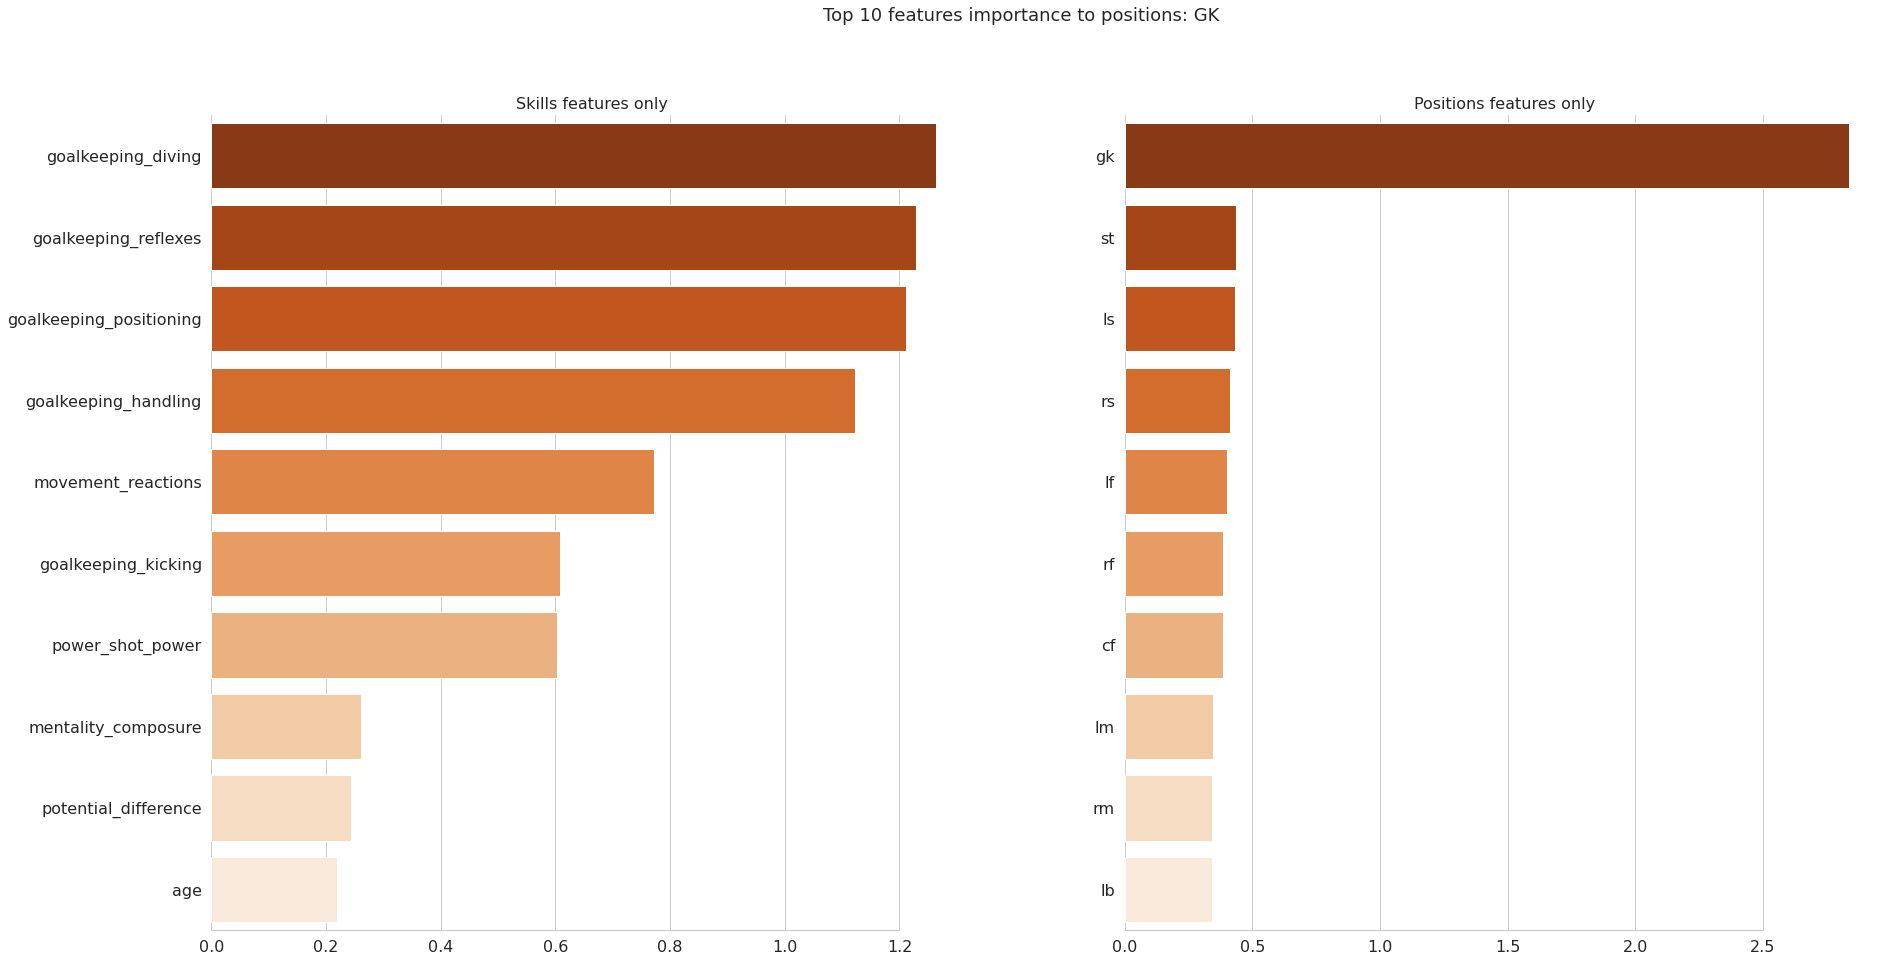

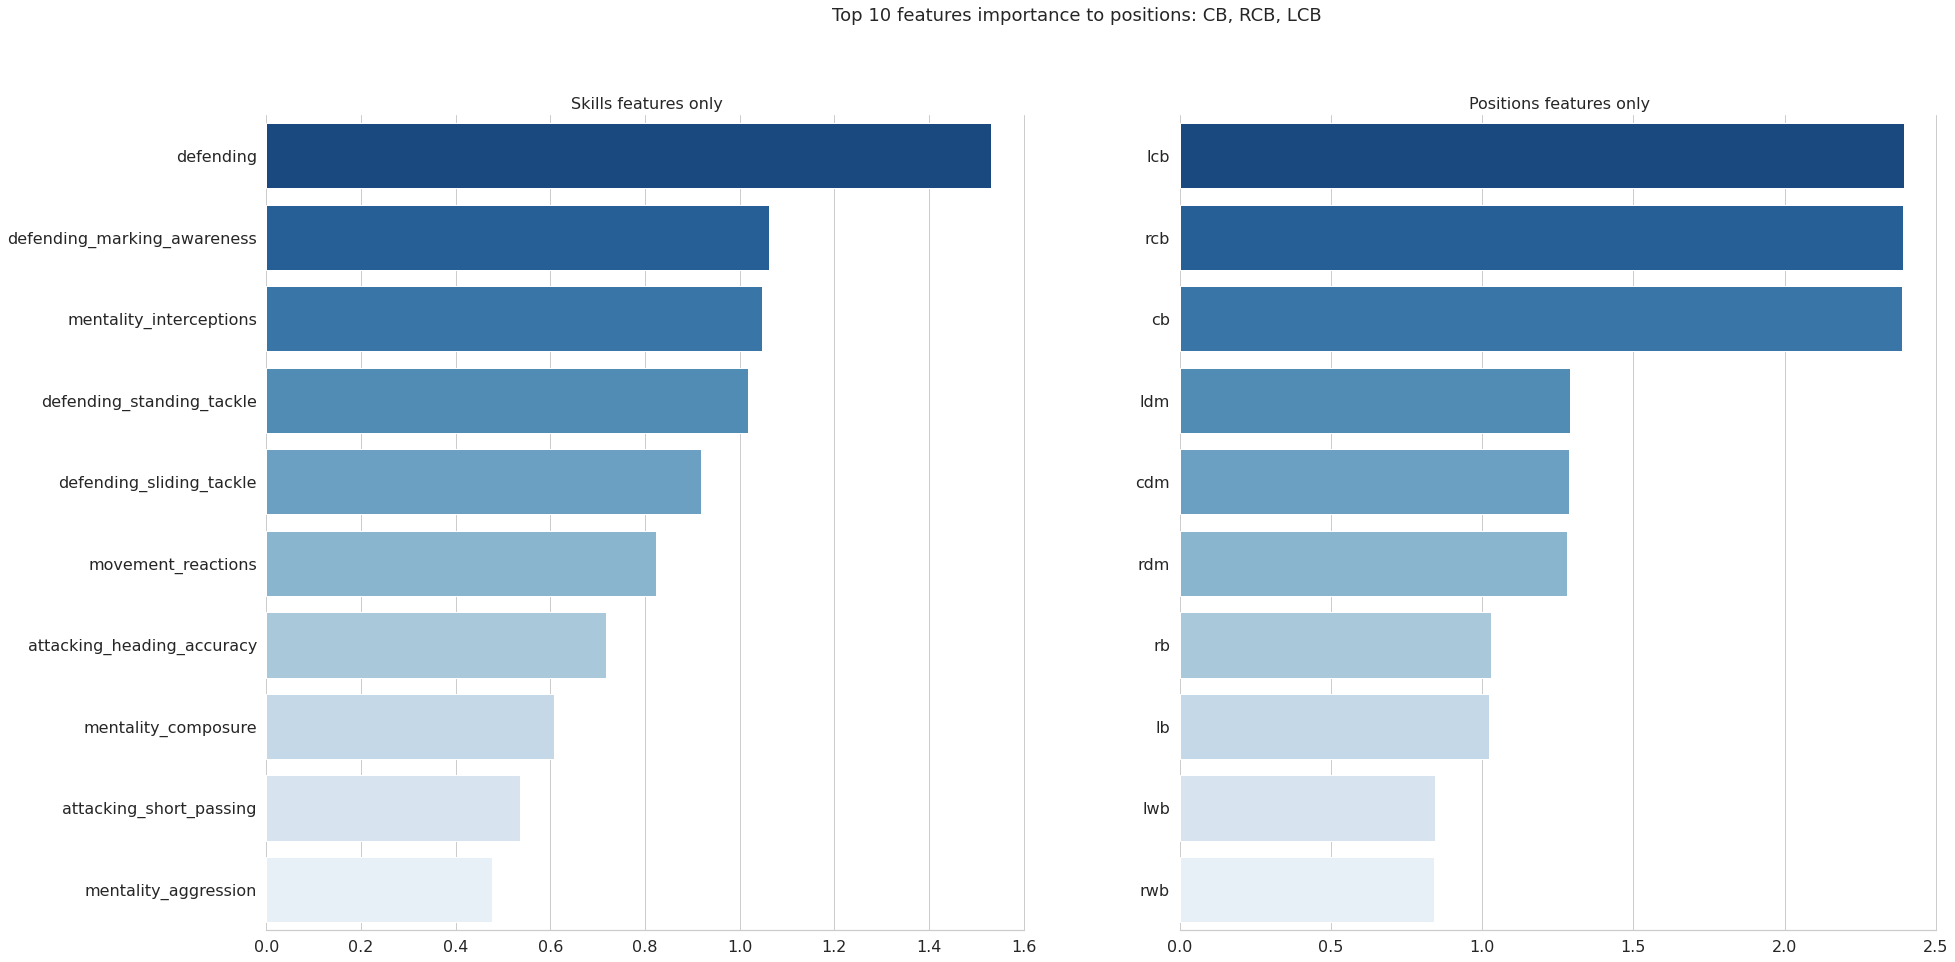

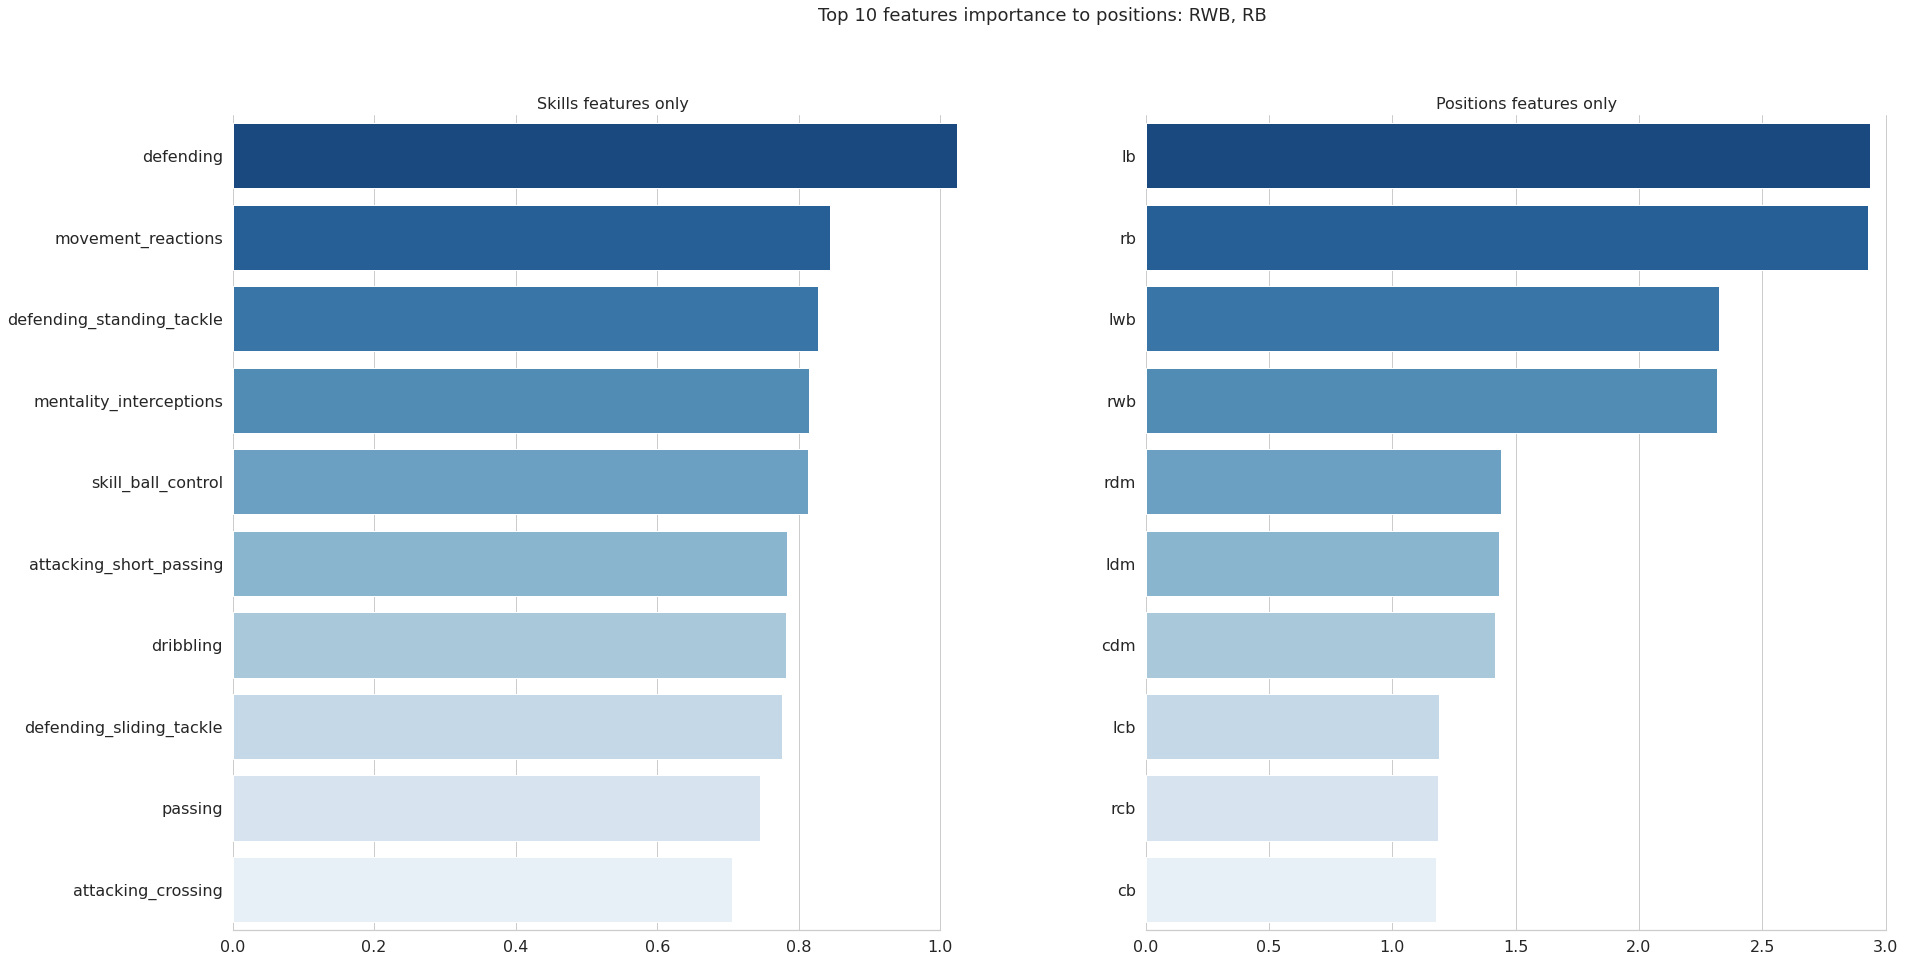

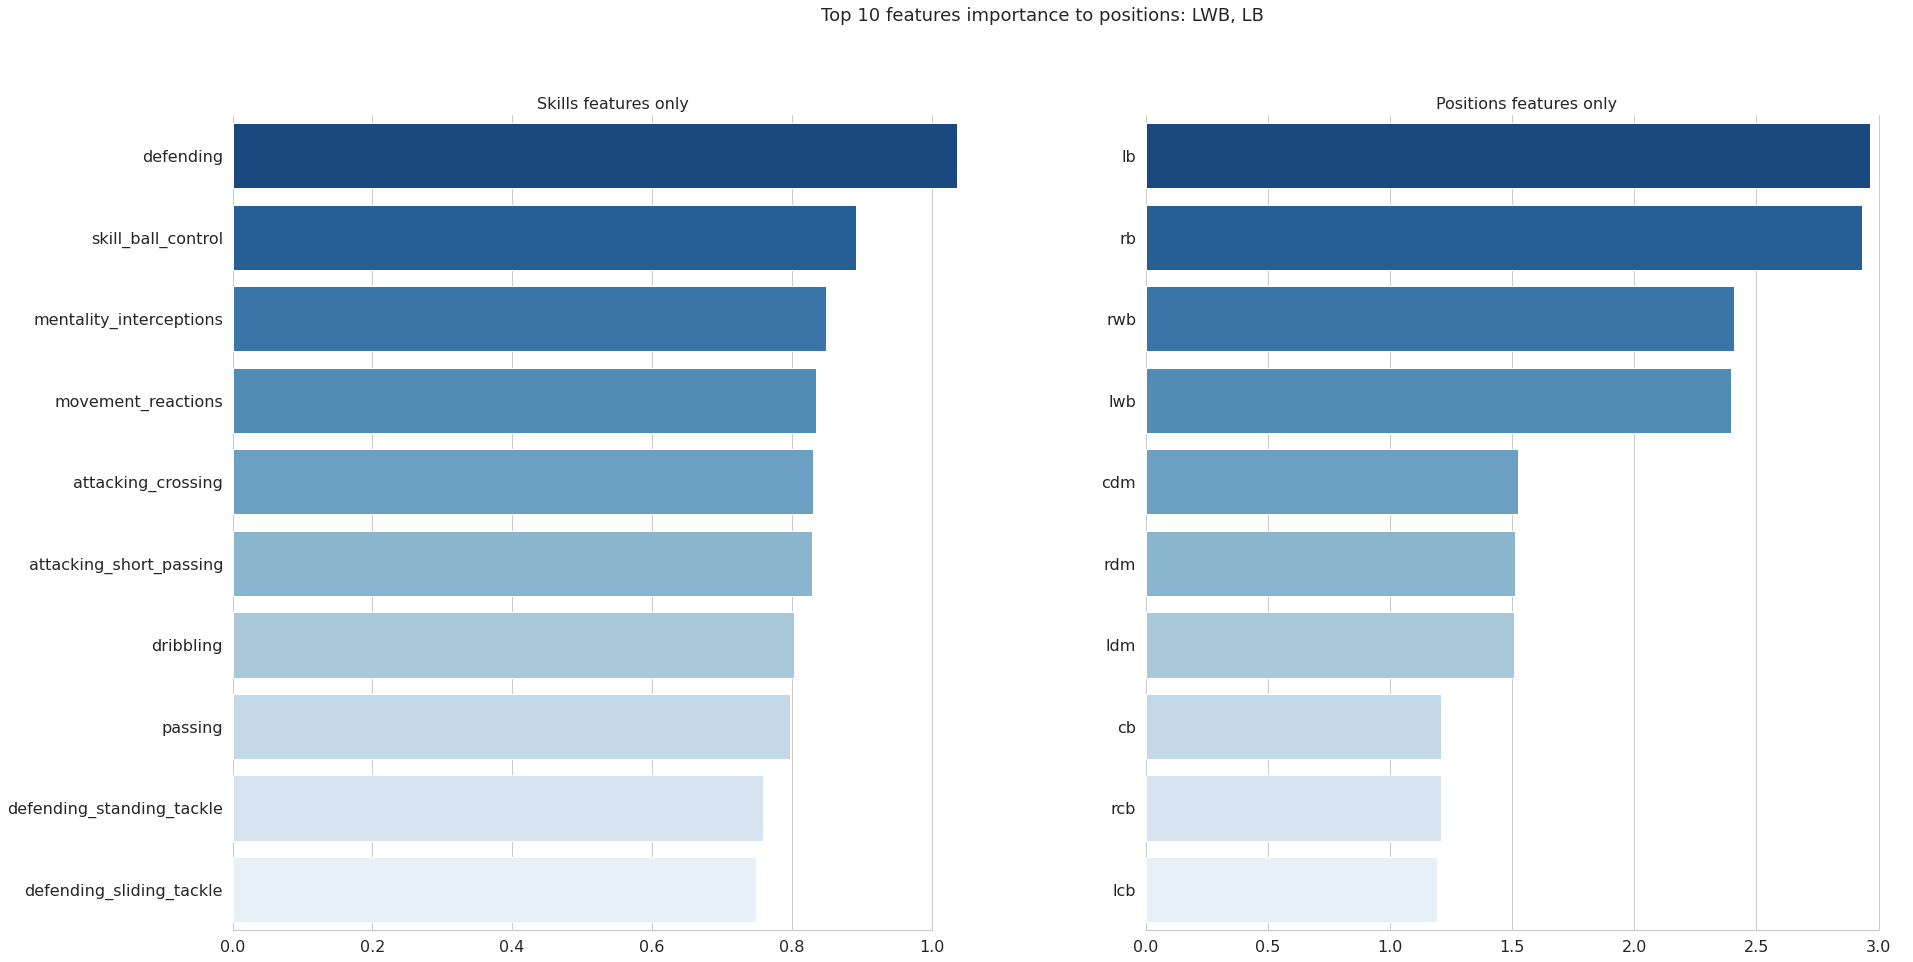

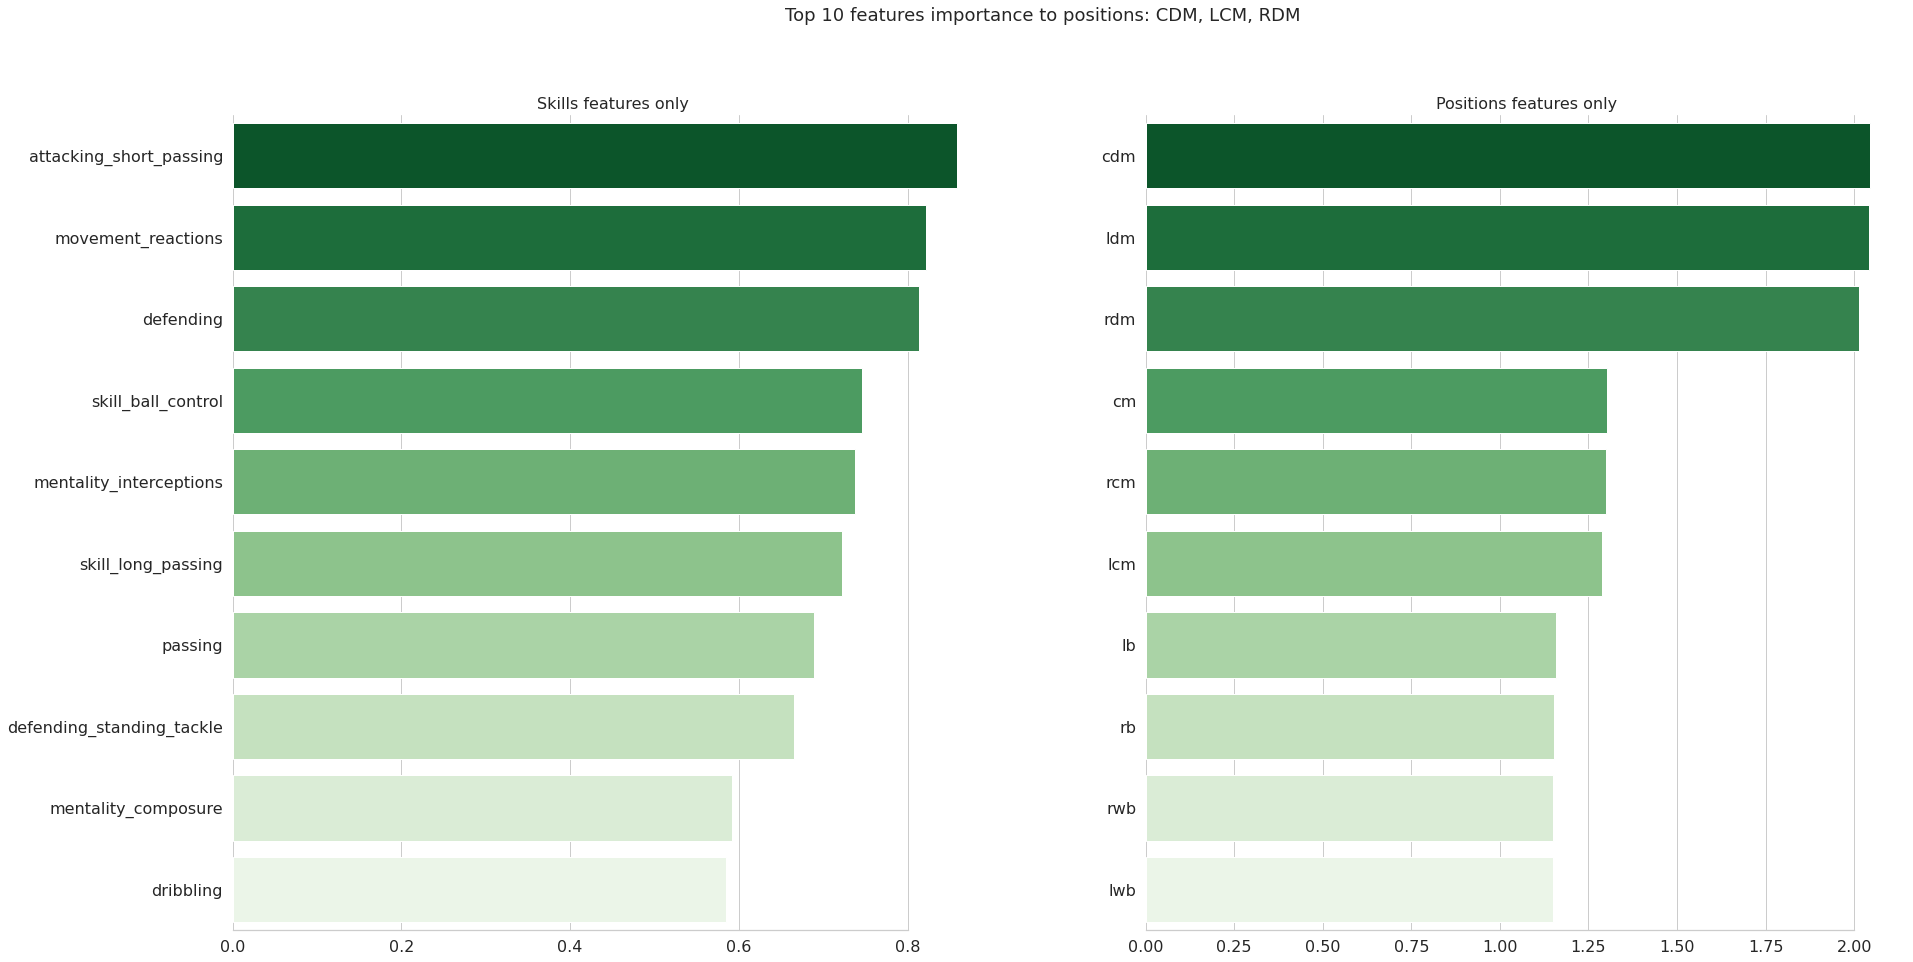

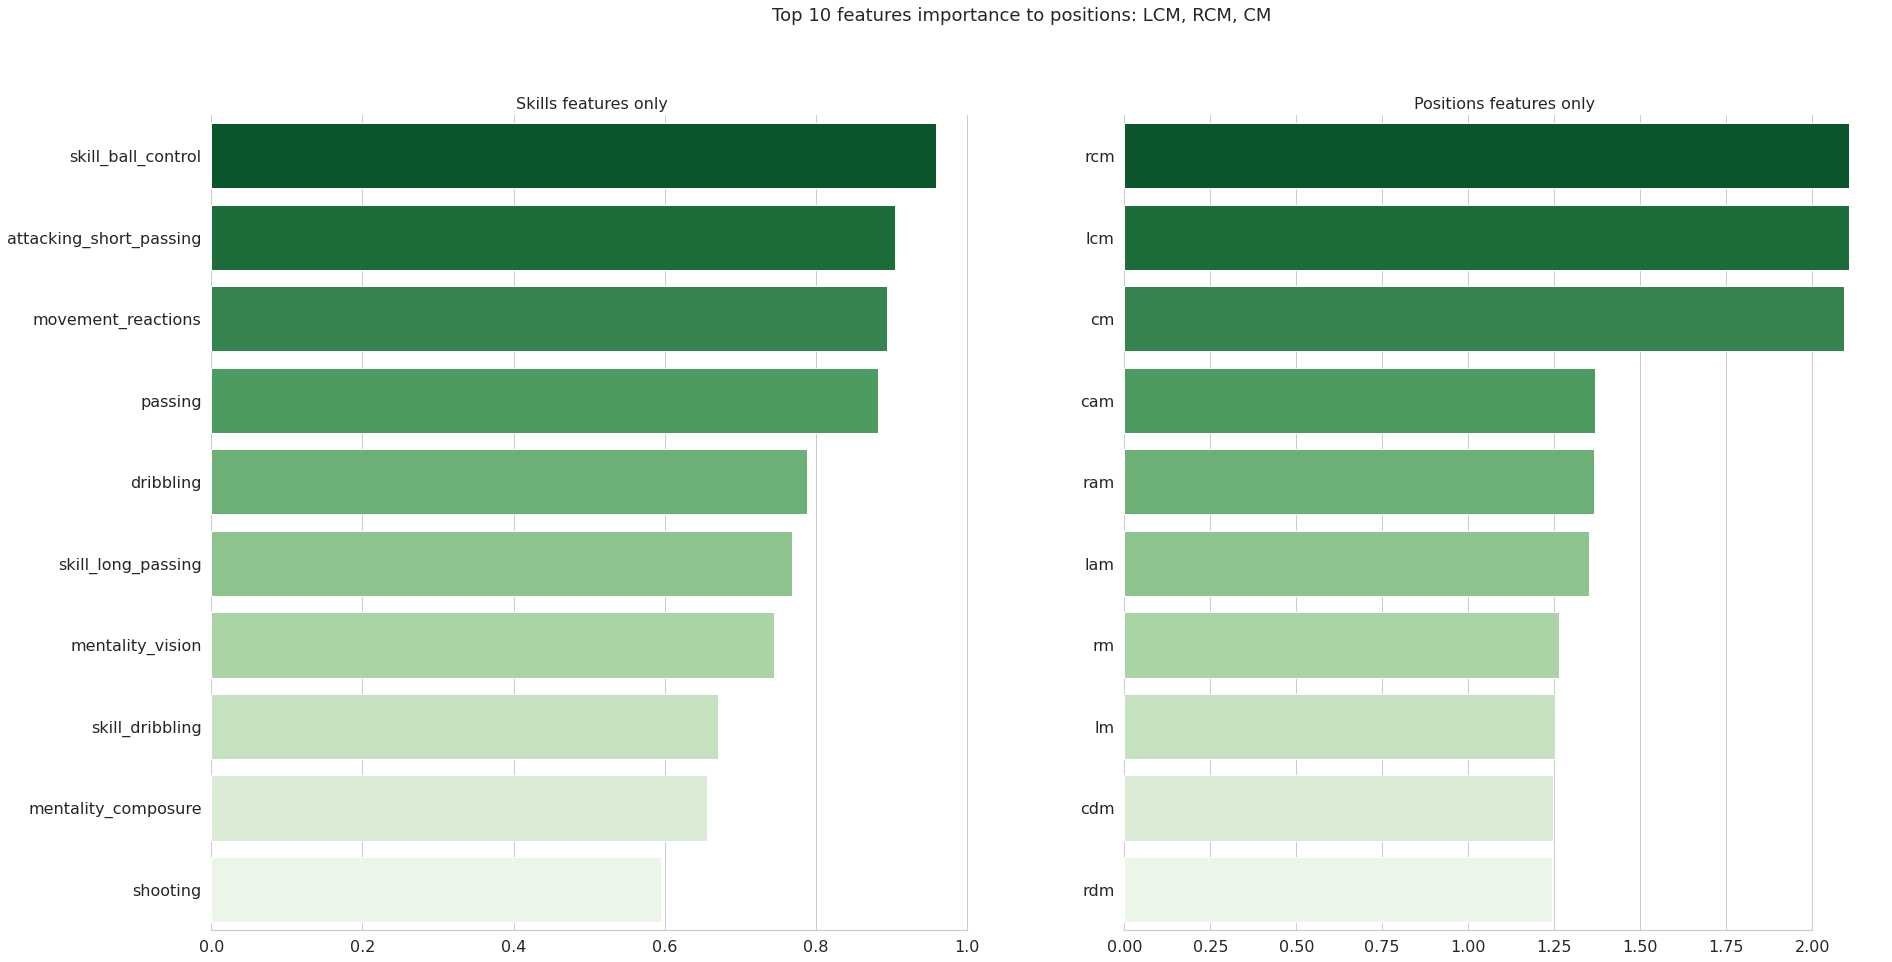

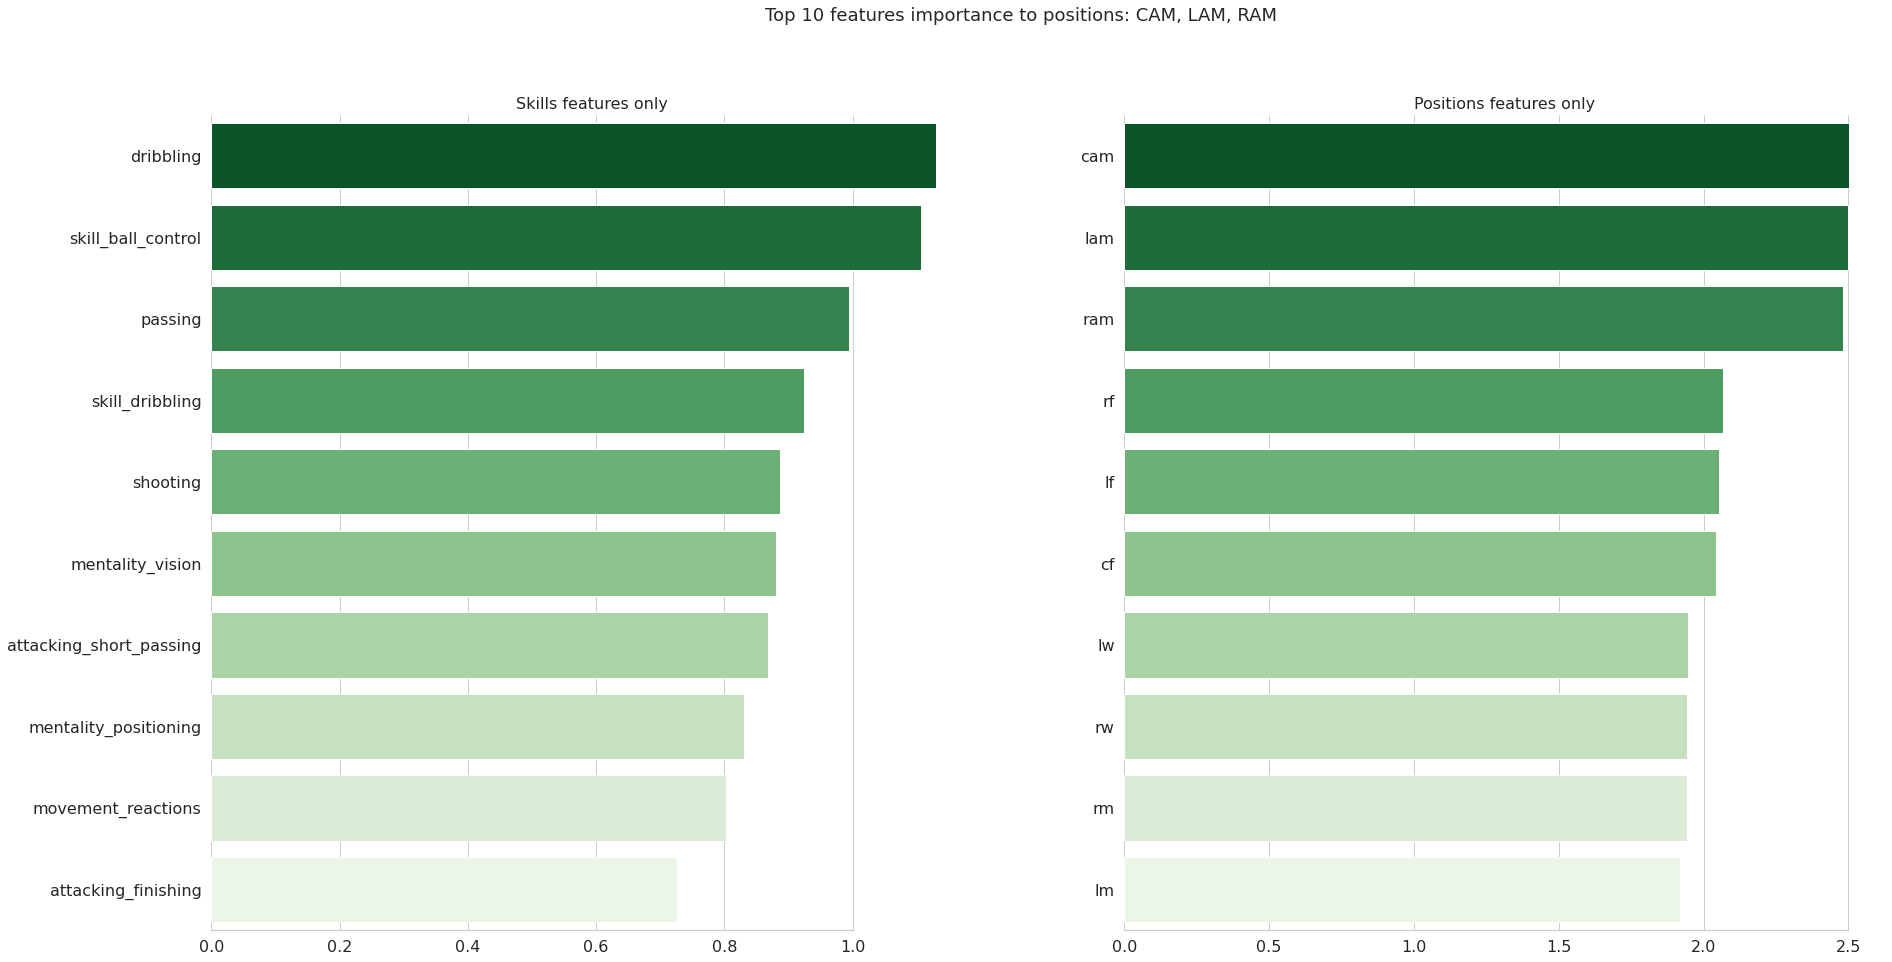

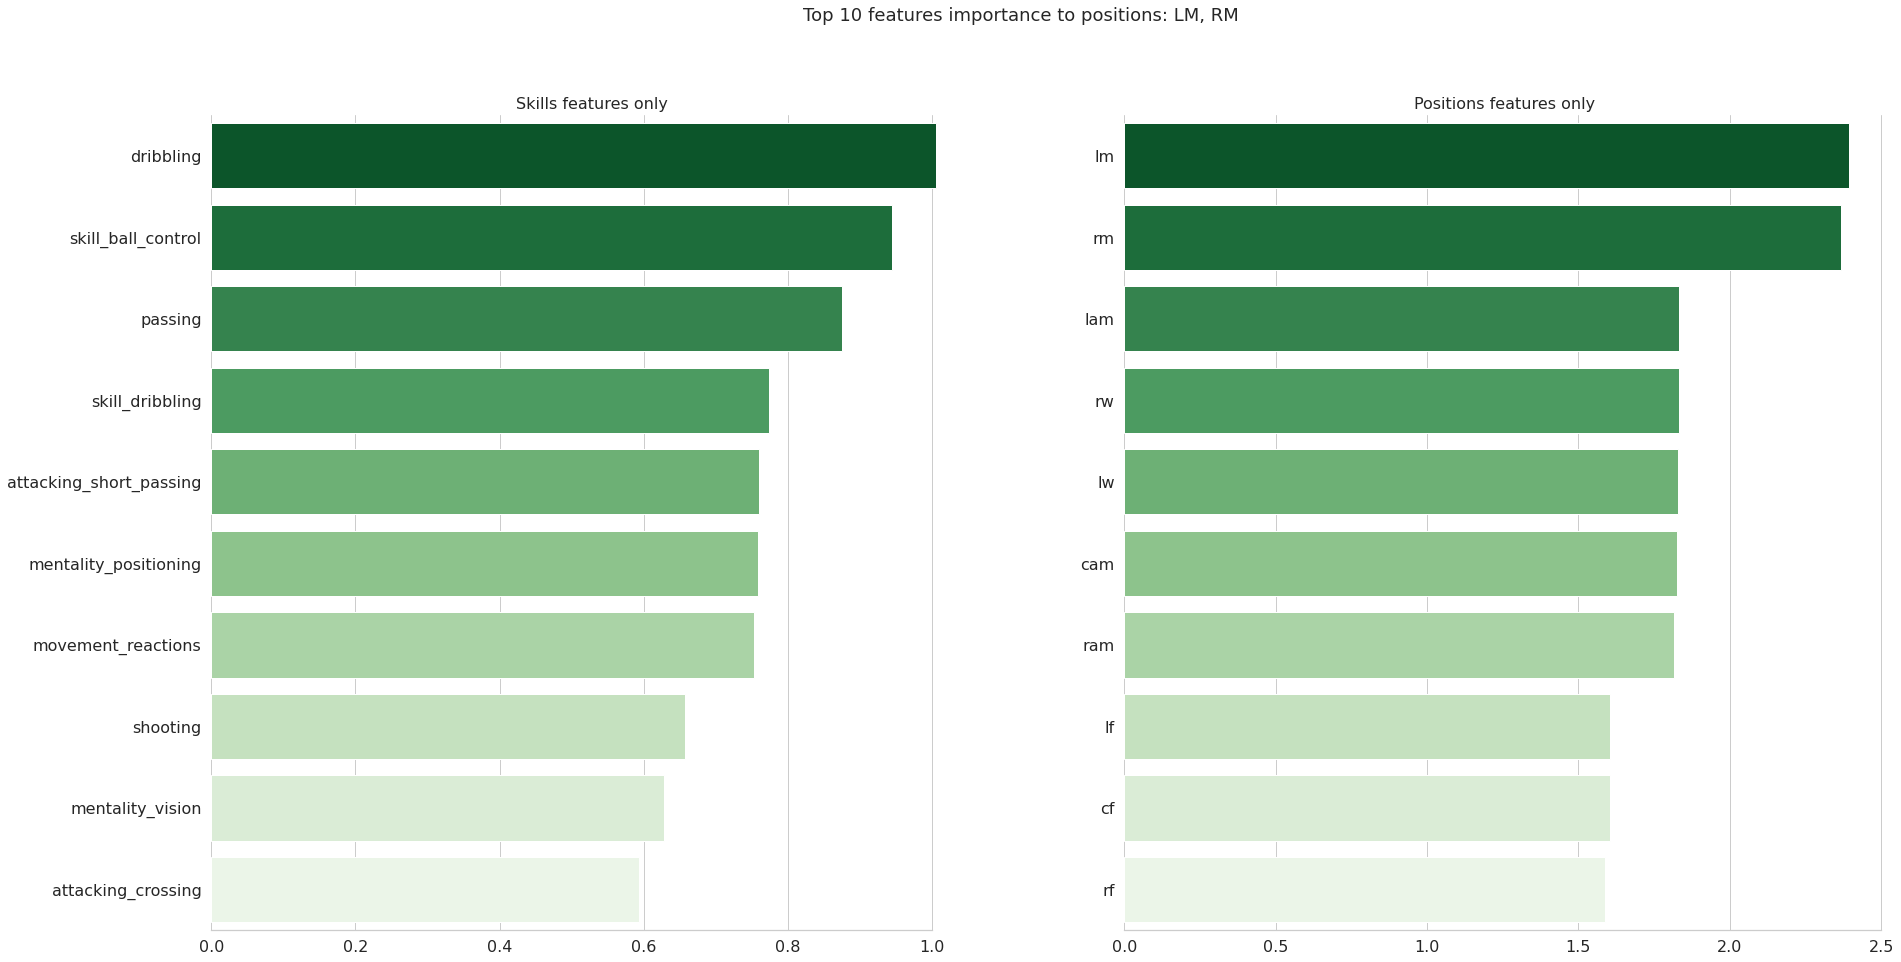

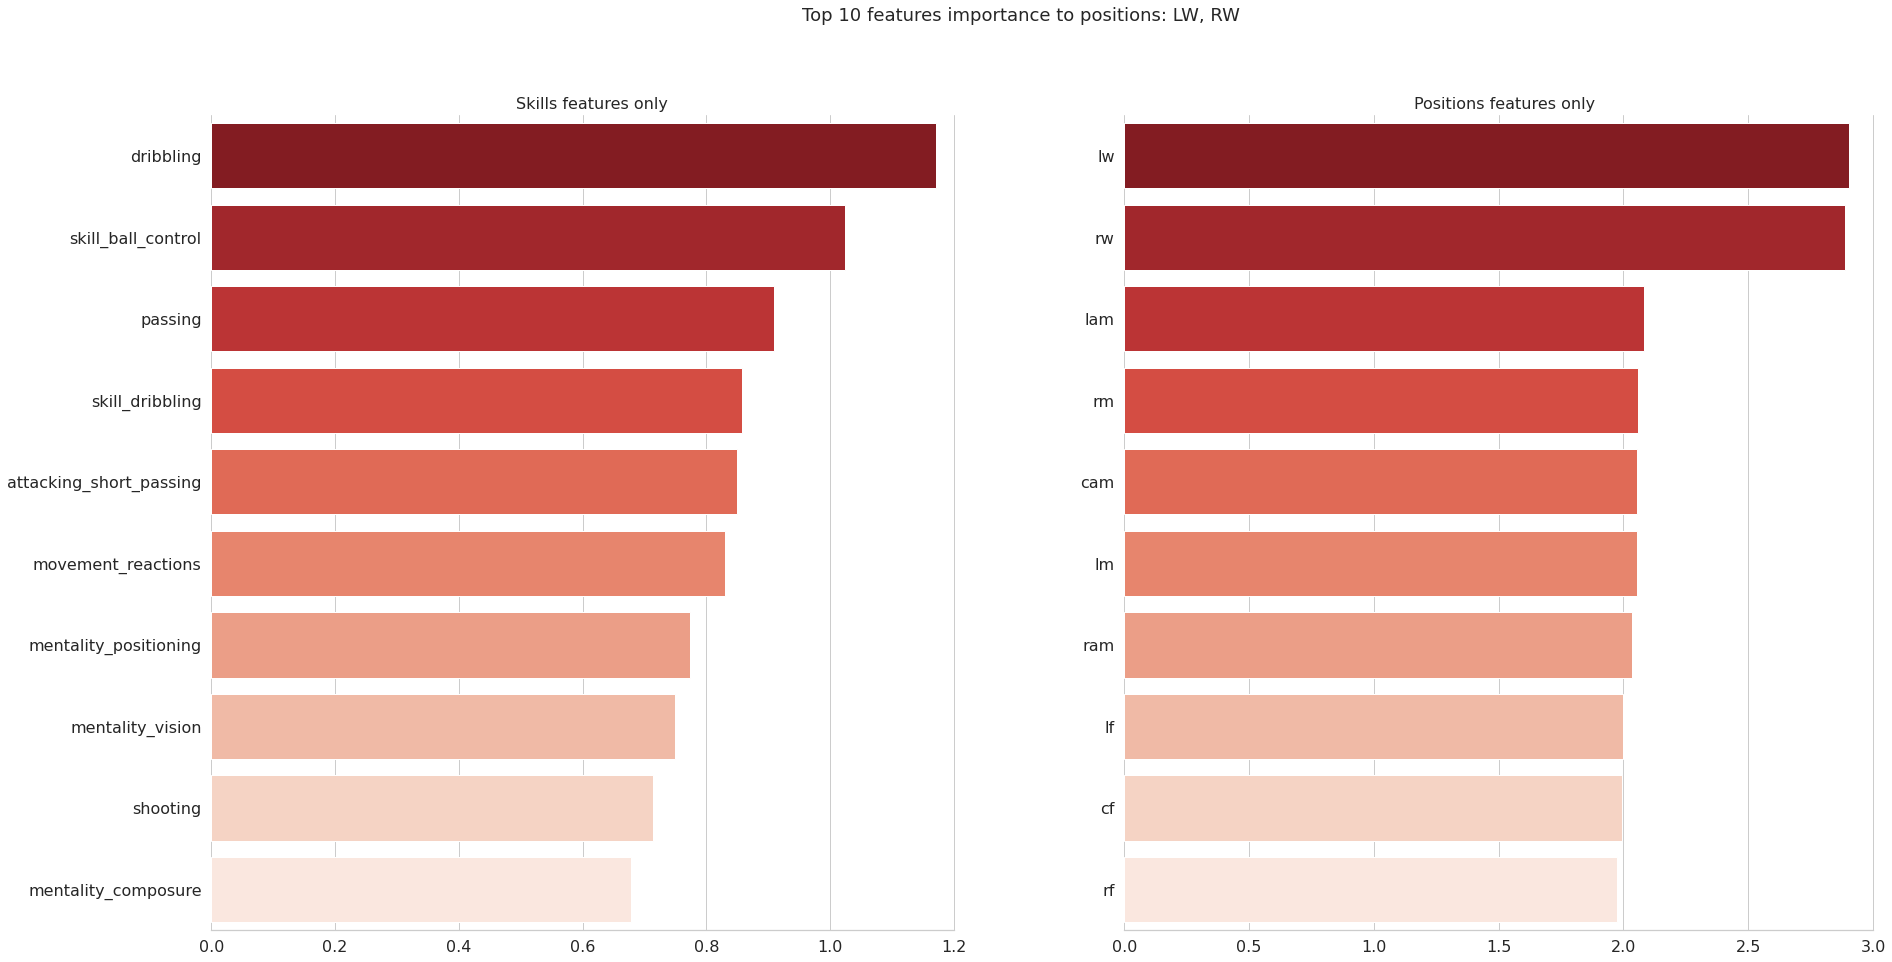

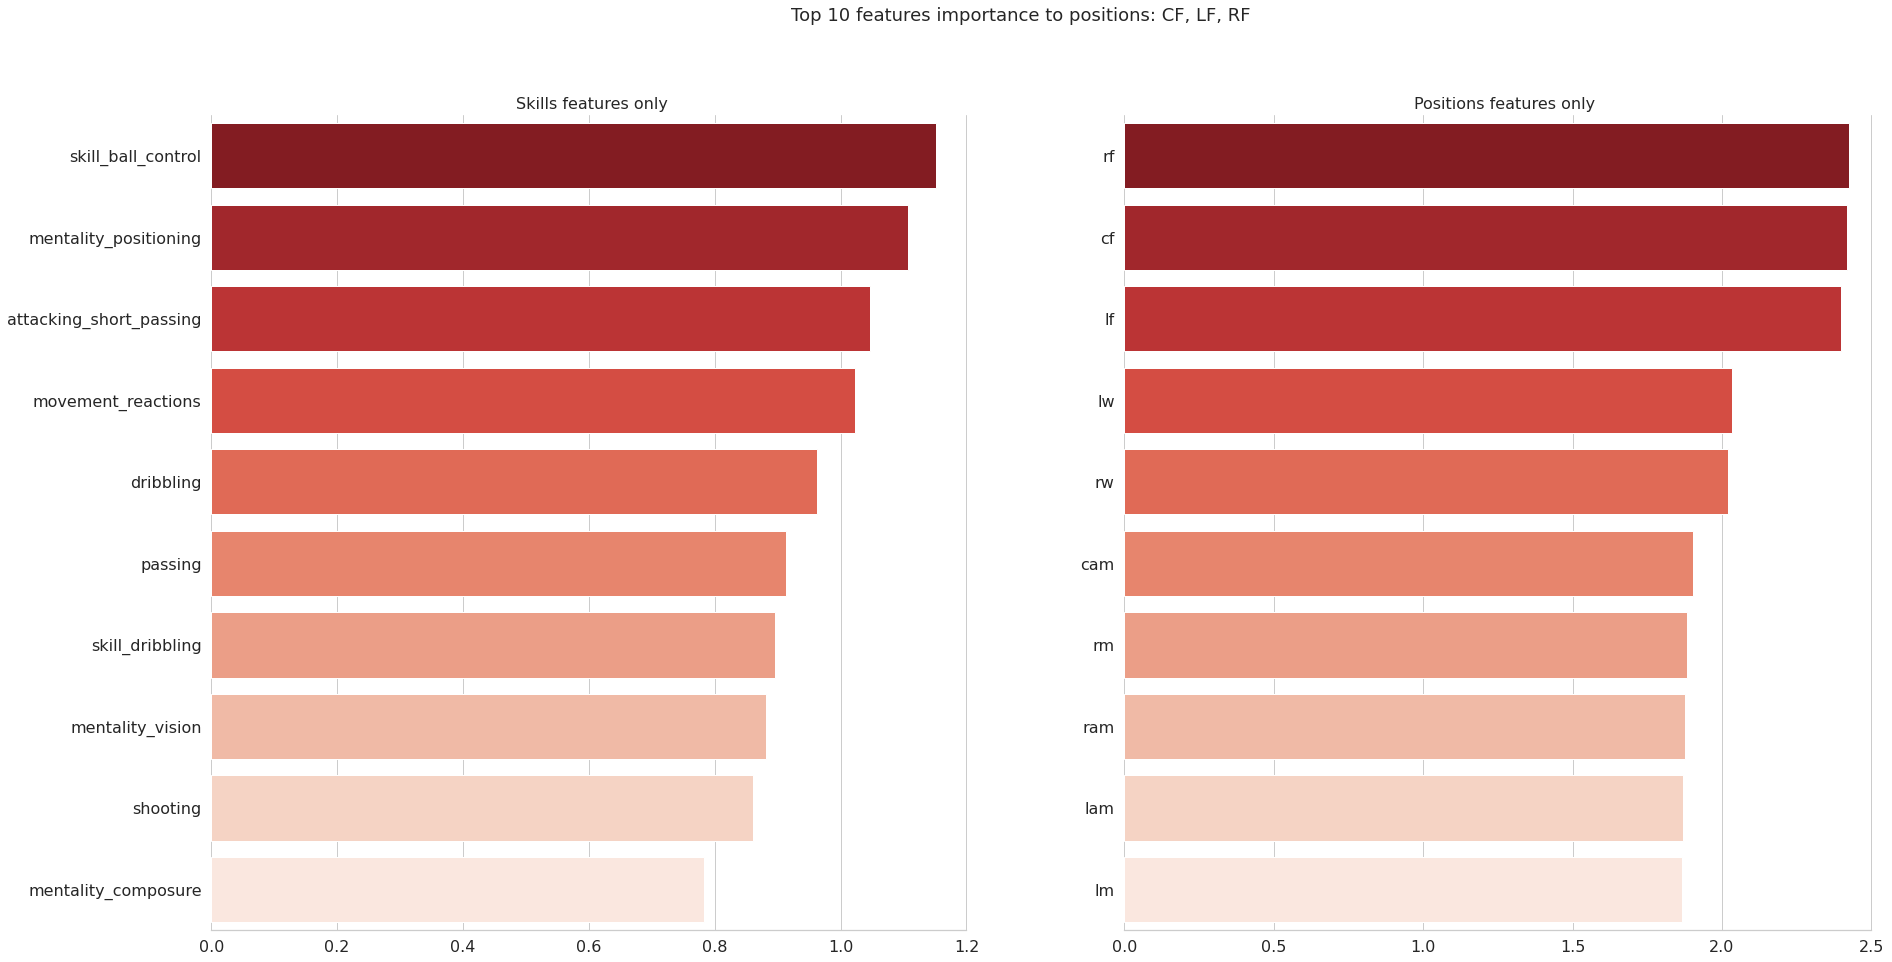

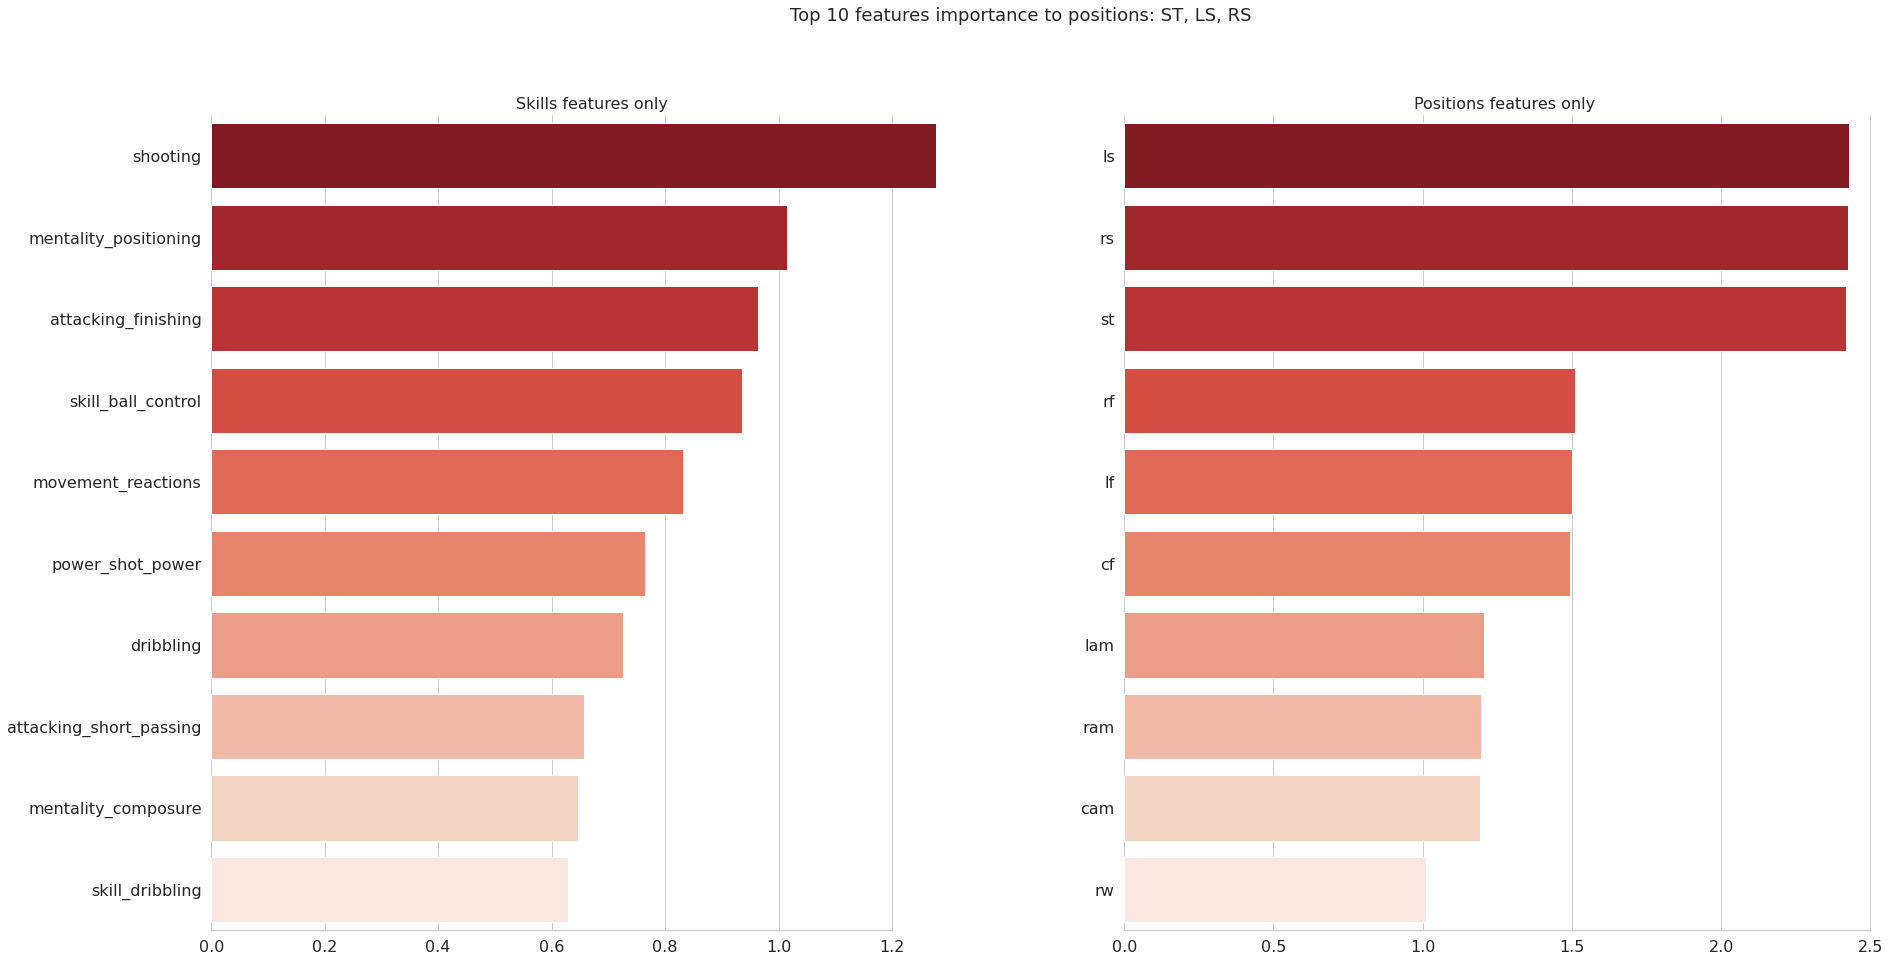

In [94]:
for positions in positions_data:
    fig, axes = plt.subplots(1, 2, sharex=False, figsize=(30, 15))
    fig.suptitle(f"Top 10 features importance to positions: {', '.join(positions)}", fontsize = 18)
    axes[0].set_title('Skills features only', fontsize = 16)
    axes[1].set_title('Positions features only', fontsize = 16)
    
    axes[0].tick_params(axis='both', which='major', labelsize = 16)
    axes[1].tick_params(axis='both', which='major', labelsize = 16)
    
    data = positions_data[positions]['scores']
    
    idx_axes0 = data[data['feature'].isin(SKILLS_FEATURES)].index
    
    sns.barplot(x = data['score'].iloc[idx_axes0].head(10).values,
                y = data['feature'].iloc[idx_axes0].head(10).values,
                palette = positions_data[positions]['color_palette'],
                ax = axes[0])
    
    idx_axes1 = data[data['feature'].isin(POSITIONS_FEATURES)].index
    
    sns.barplot(x = data['score'].iloc[idx_axes1].head(10).values,
                y = data['feature'].iloc[idx_axes1].head(10).values,
                palette = positions_data[positions]['color_palette'],
                ax = axes[1])
    
    sns.despine(trim=True, left=True)


## 4.2 (GK) Goalkeeper
- **G. Donnarumma, J. Oblak, M. Ter Stegen, Alisson, and Ederson stand out in the three main goalkeeper skills, but they are very expensive.**
- **K. Navas and H. Lloris also stand out in the three main characteristics and are approximately 80% cheaper compared to the most expensive goalkeepers.**
- **G. Ochoa and S. Mandanda stand out in two and three goalkeeper skills, respectively. Both cost less than 3 million.**

In [95]:
def prepare_data(df, n = 'all', sort = None, ascending = None, cost = None, filter_value = None):
    if sort:
        df.sort_values(by = sort, ascending = ascending, inplace = True)        
    
    if cost:
        df = df[df[filter_value['col']] >=filter_value['val']].copy()
        df['cost'] = df[cost[0]] / df[cost[1]]
        df.sort_values(by = 'cost', ascending = False, inplace = True)
    
    df.reset_index(drop = True, inplace = True)
    return df.head(n) if type(n) is int else df

In [96]:
def millions(x, pos):
    'The two args are the value and tick position'
    # return '%1.0fmi' % (x*1e-6)
    return f'{x*1e-6:.1f}mi' if x*1e-6 < 10 else '%1.0fmi' % (x*1e-6)


def plot_scatter(df, x, y, title, style = None, hue = None):
    names = list()
    
    plt.figure(figsize = (20, 10))
    ax = sns.scatterplot(  data = df
                         , x = x, y = y
                         , style = style
                         , s   = 100
                         , hue = hue
                          )
    ax.set_title(title, fontsize = 16)
    sns.despine(trim=True, left=True)
    
    formatter = FuncFormatter(millions)
    ax.xaxis.set_major_formatter(formatter)
    
    yticks = range(int(min(df[y])), int(max(df[y]))+1, 1)
    plt.yticks(yticks)
    
    for i in range(len(df)):
        names.append(plt.annotate(df['short_name'][i], (df[x][i], df[y][i])))
        
    adjust_text(texts=names, ax=ax)

### BEST GOALKEEPERS

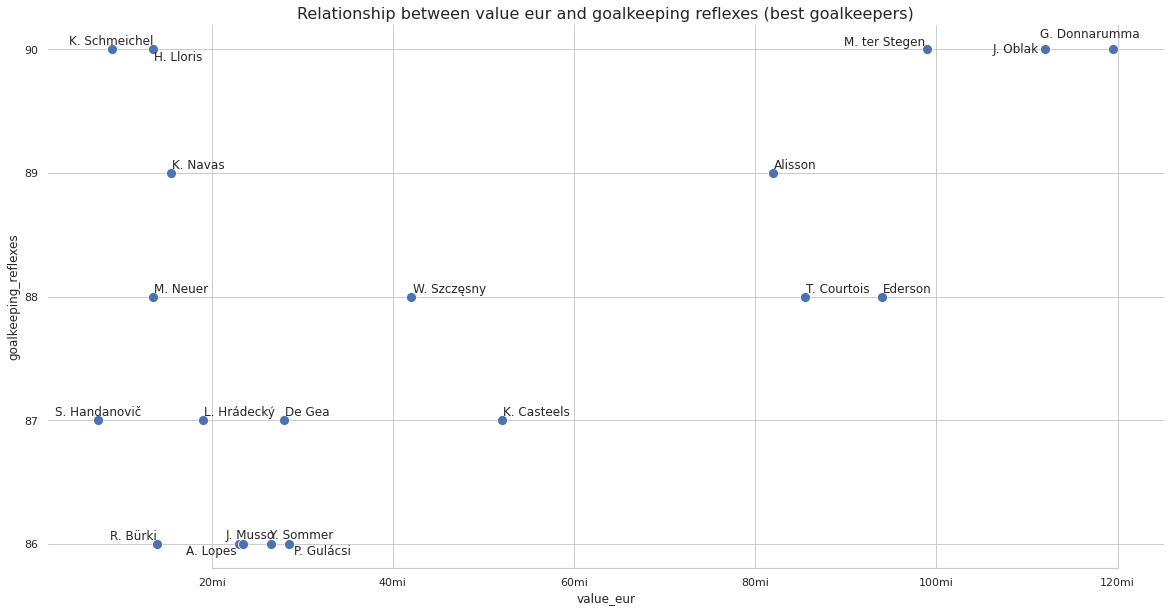

In [97]:
data = prepare_data(df = positions_data[('GK',)]['analysis'], n = 20, sort = ['goalkeeping_reflexes', 'value_eur'], ascending = [False, True])
plot_scatter(df = data, x = 'value_eur', y = 'goalkeeping_reflexes', title = f"Relationship between value eur and goalkeeping reflexes (best goalkeepers)")

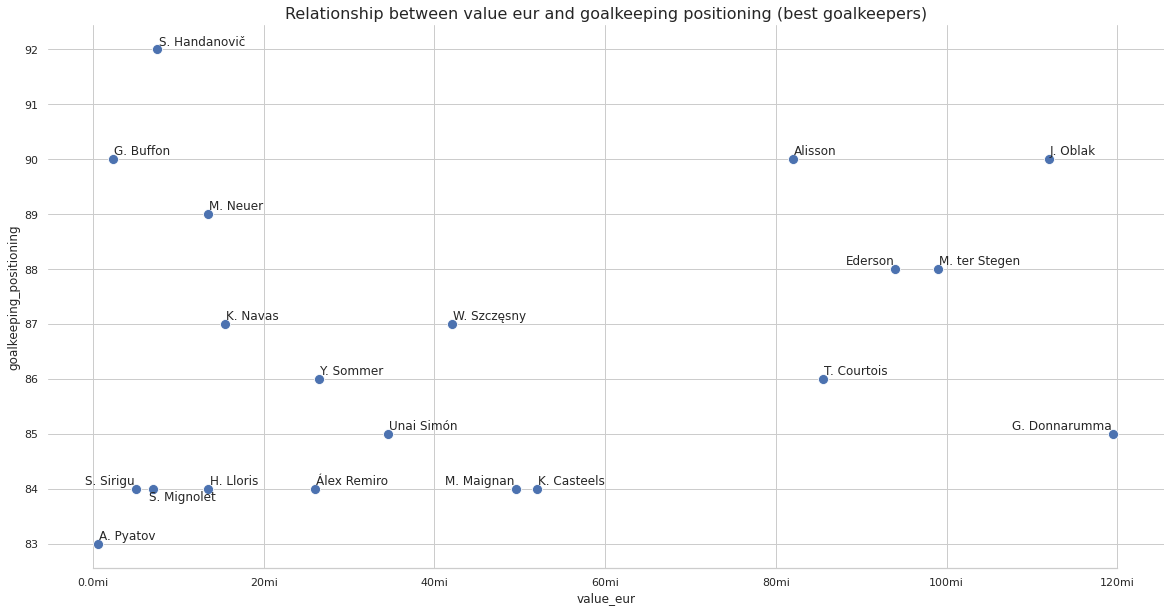

In [98]:
data = prepare_data(df = positions_data[('GK',)]['analysis'], n = 20, sort = ['goalkeeping_positioning', 'value_eur'], ascending = [False, True])
plot_scatter(df = data, x = 'value_eur', y = 'goalkeeping_positioning', title = f"Relationship between value eur and goalkeeping positioning (best goalkeepers)")

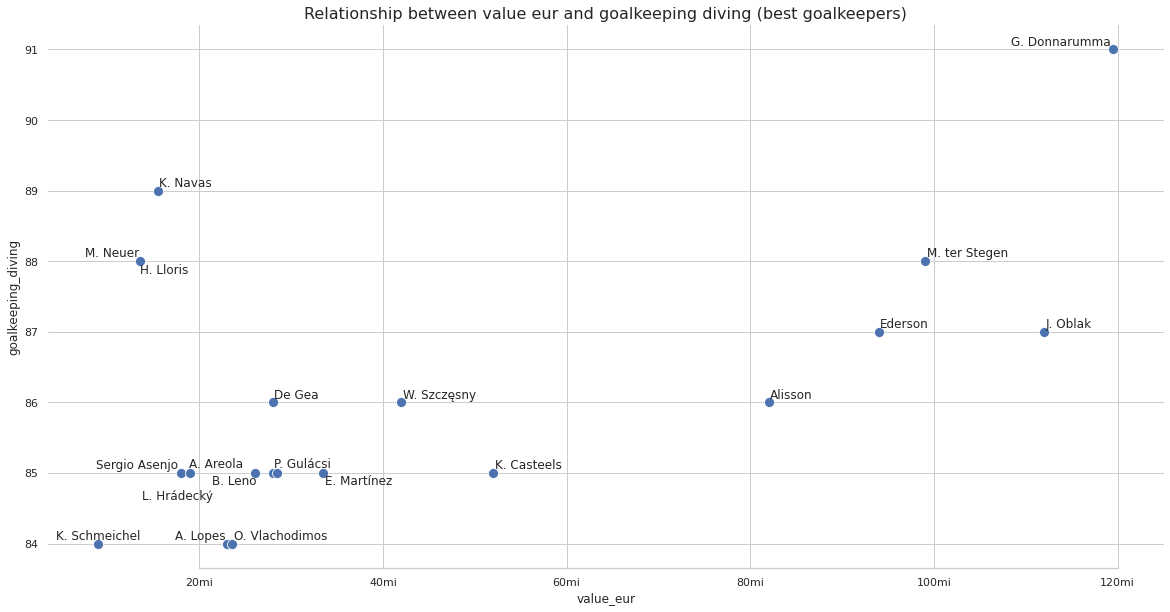

In [99]:
data = prepare_data(df = positions_data[('GK',)]['analysis'], n = 20, sort = ['goalkeeping_diving', 'value_eur'], ascending = [False, True])
plot_scatter(df = data, x = 'value_eur', y = 'goalkeeping_diving', title = f"Relationship between value eur and goalkeeping diving (best goalkeepers)")

### GOOD AND CHEAP GOALKEEPERS

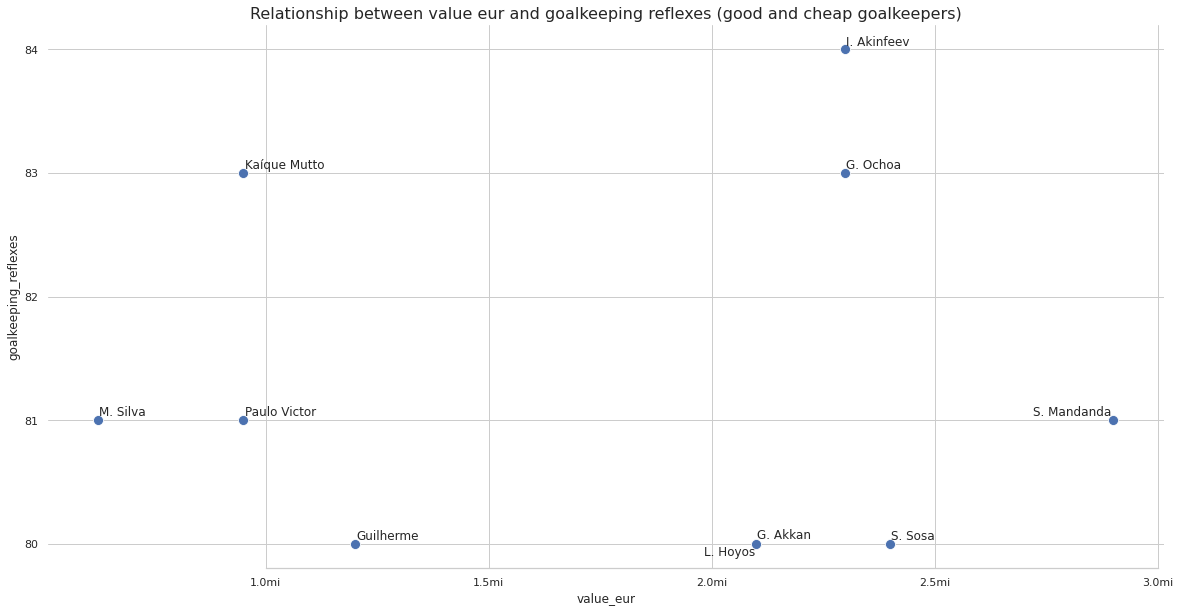

In [100]:
data = prepare_data(df = positions_data[('GK',)]['analysis'], n = 10, cost=['goalkeeping_reflexes', 'value_eur'], filter_value = {'col': 'goalkeeping_reflexes', 'val': 80})
plot_scatter(df = data, x = 'value_eur', y = 'goalkeeping_reflexes', title = f"Relationship between value eur and goalkeeping reflexes (good and cheap goalkeepers)")

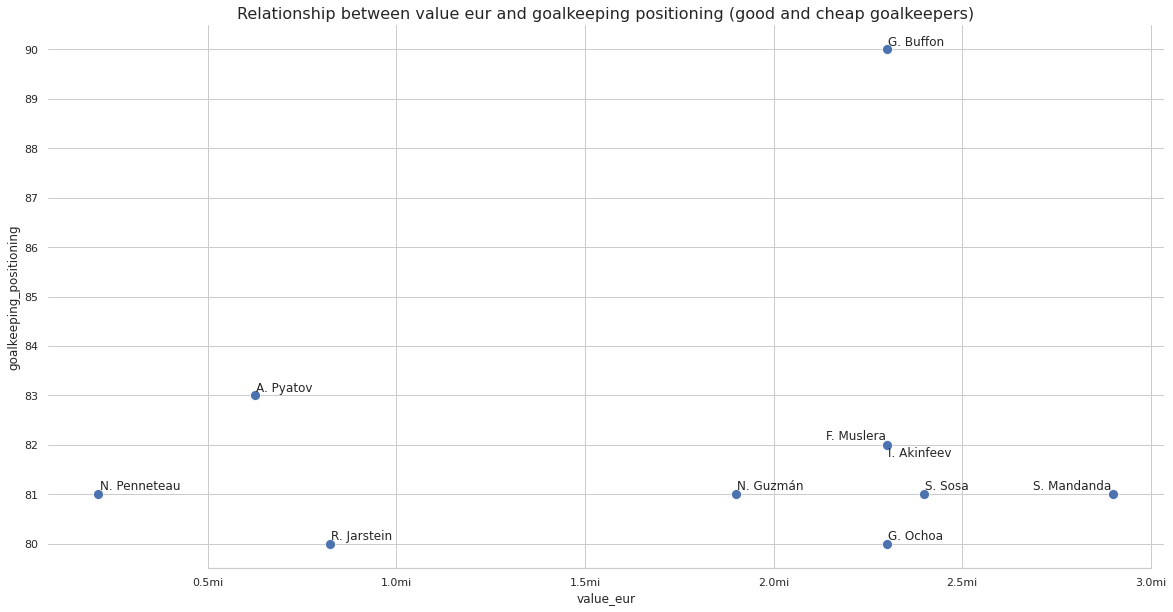

In [101]:
data = prepare_data(df = positions_data[('GK',)]['analysis'], n = 10, cost=['goalkeeping_positioning', 'value_eur'], filter_value = {'col': 'goalkeeping_positioning', 'val': 80})
plot_scatter(df = data, x = 'value_eur', y = 'goalkeeping_positioning', title = f"Relationship between value eur and goalkeeping positioning (good and cheap goalkeepers)")

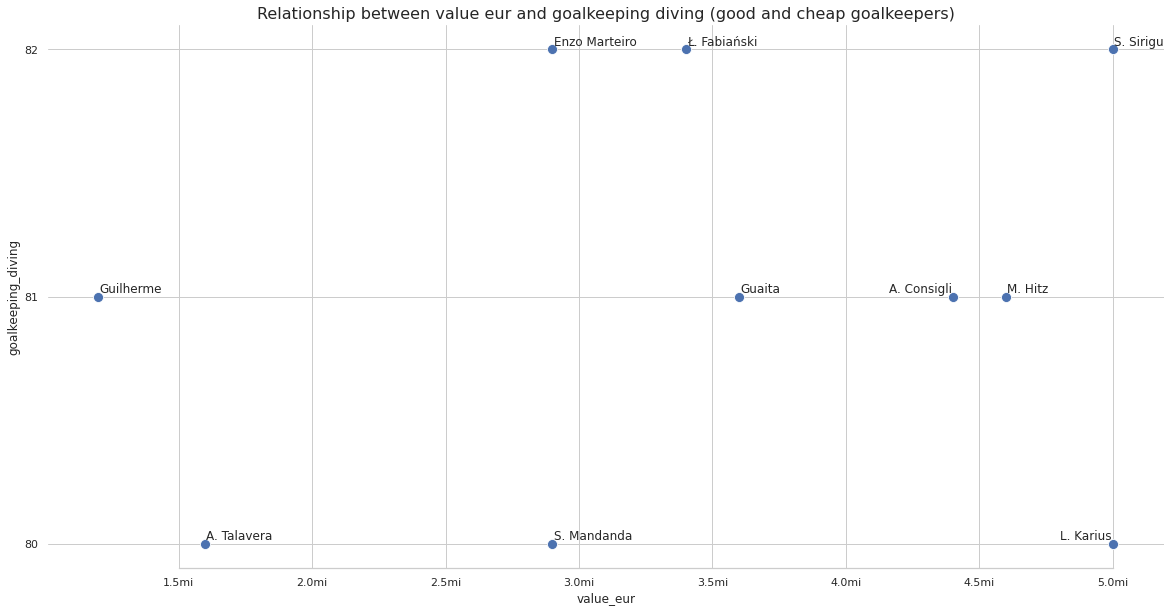

In [102]:
data = prepare_data(df = positions_data[('GK',)]['analysis'], n = 10, cost=['goalkeeping_diving', 'value_eur'], filter_value = {'col': 'goalkeeping_diving', 'val': 80})
plot_scatter(df = data, x = 'value_eur', y = 'goalkeeping_diving', title = f"Relationship between value eur and goalkeeping diving (good and cheap goalkeepers)")

## 4.3 Defense
- **The Italian school of defense continues to excel compared to other nations.**
- **The top 10 nations with the best defenders consist of 6 Europeans and 4 South Americans.**

In [103]:
data = positions_data[('CB', 'RCB', 'LCB')]['analysis']

valid_nationality = list()
nationality_list = np.unique(data['nationality_name'], return_counts = True) 

for nation, count in zip(nationality_list[0], nationality_list[1]):
    if count > 50:
        valid_nationality.append(nation)
        
data = data[data['nationality_name'].isin(valid_nationality)].copy()
order_data = data.groupby('nationality_name')['defending'].median().sort_values(ascending = False).index.tolist()

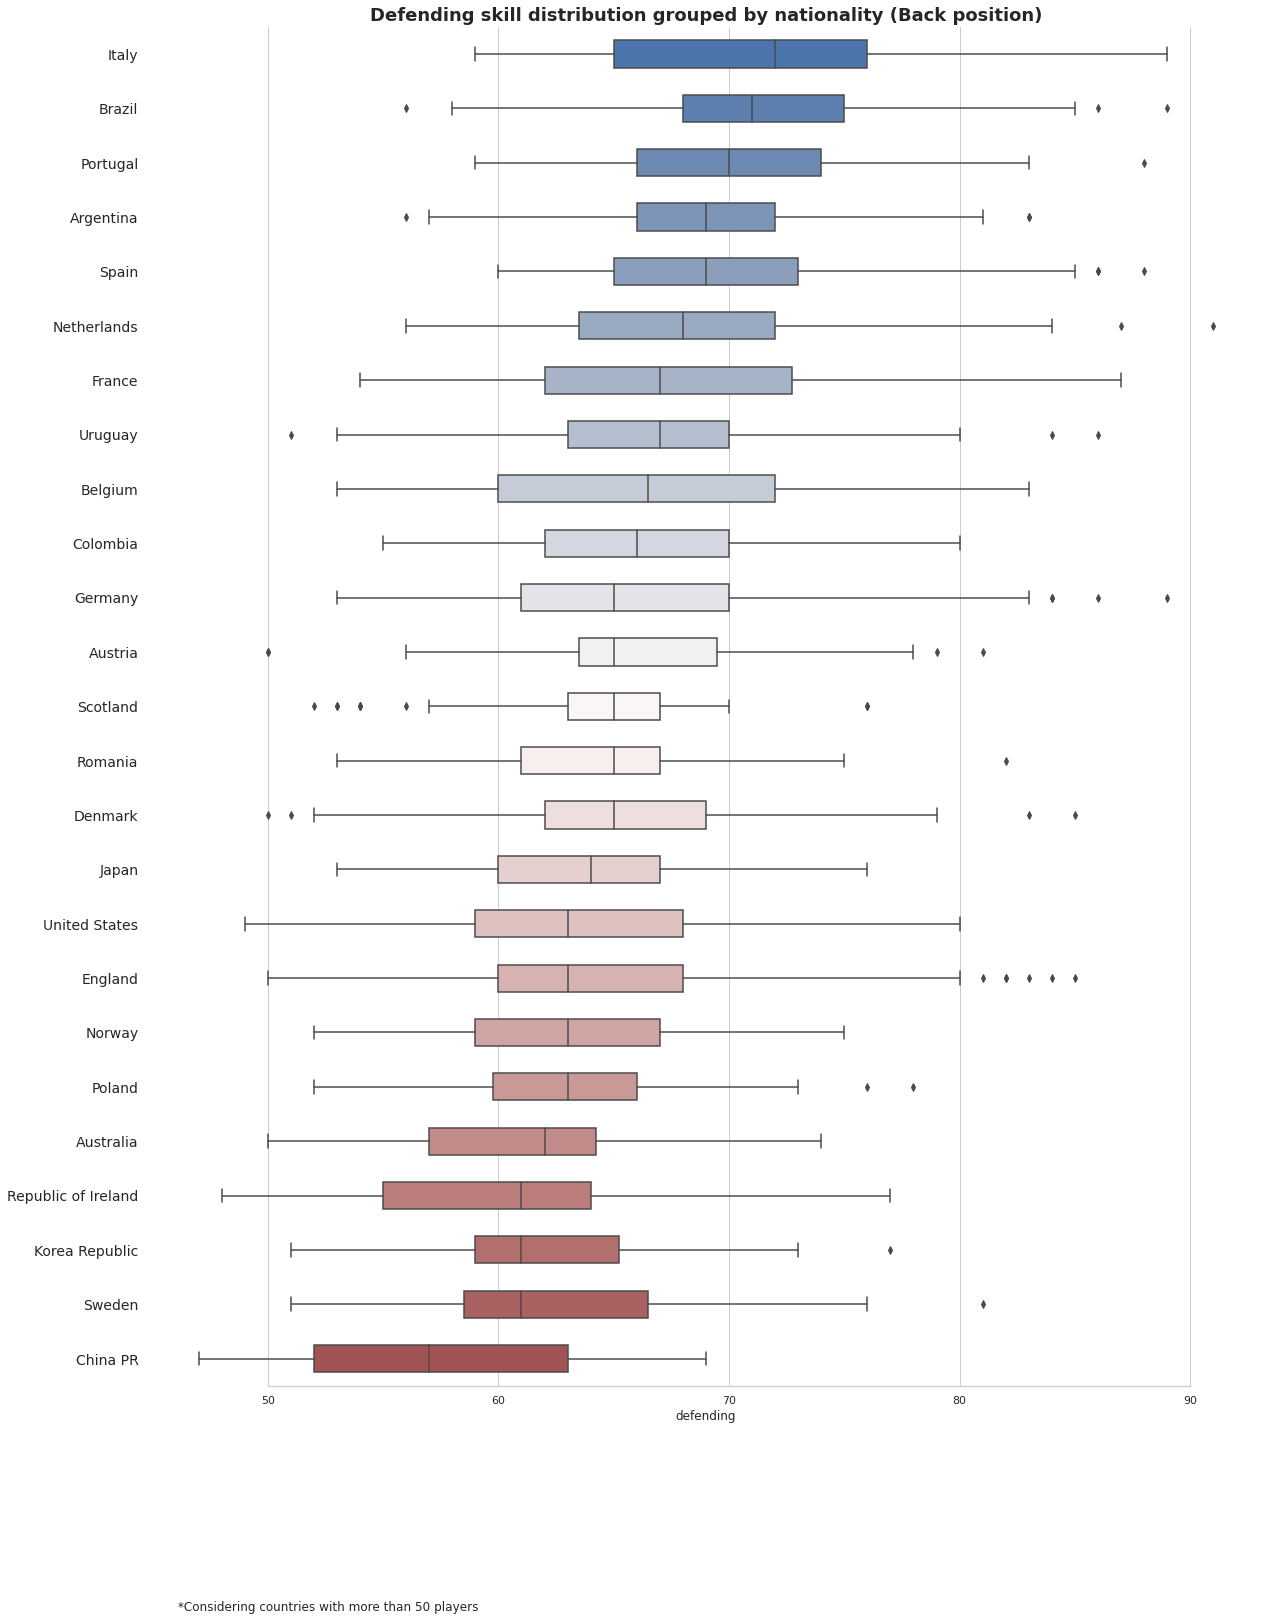

In [104]:
f, ax = plt.subplots(figsize=(20, 25))

sns.boxplot(x="defending", y="nationality_name", data=data
            , order = order_data
            , width=.5, palette="vlag")

ax.set_title('Defending skill distribution grouped by nationality (Back position)', fontsize = 18, fontweight='bold')
plt.figtext(0.25, 0, "*Considering countries with more than 50 players", ha="center", fontsize=12)

plt.yticks(fontsize=14)
ax.set(ylabel="")
ax.xaxis.grid(True)
sns.despine(trim=True, left=True)

In [105]:
data_right = positions_data[('RWB', 'RB')]['analysis']
data_right['side'] = 'Right Winger'

data_left = positions_data[('LWB', 'LB')]['analysis']
data_left['side'] = 'Left Winger'

data = pd.concat([data_right, data_left])
data_attack = data[data['attacking_crossing'] >= 65].groupby(by='side').count().reset_index()
data_defense = data[data['defending_standing_tackle'] >= 65].groupby(by='side').count().reset_index()

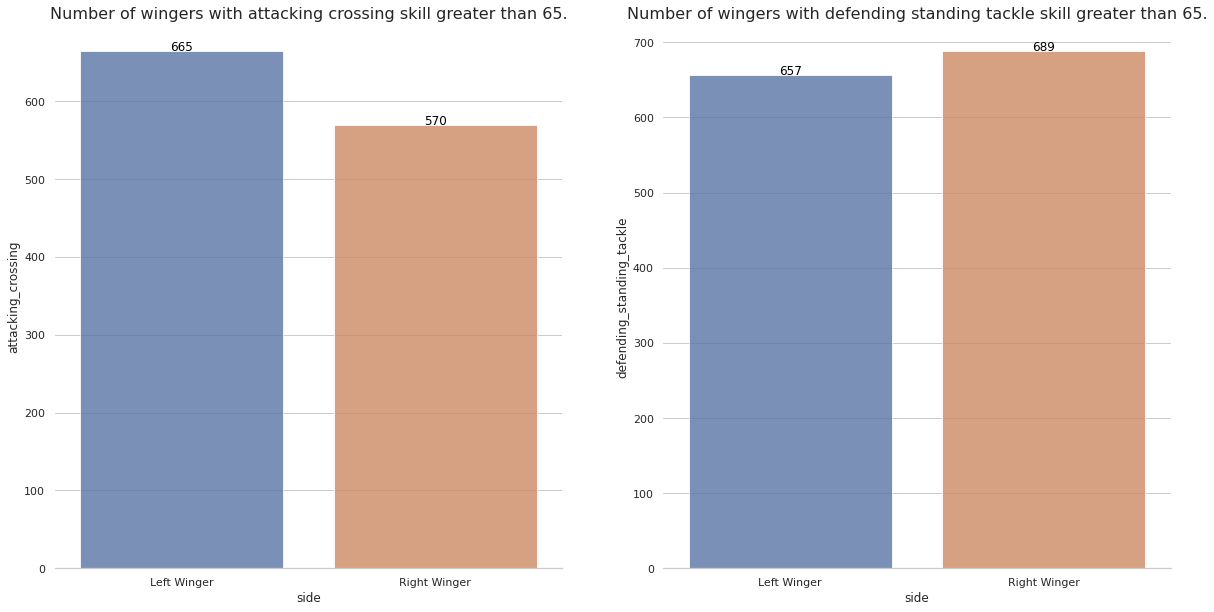

In [106]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(20, 10))

axes[0].set_title('Number of wingers with attacking crossing skill greater than 65.', fontsize=16)
sns.barplot(
    data=data_attack,
    x="side", y="attacking_crossing",
    palette="deep", alpha=.8,
    ax = axes[0])
for i, v in enumerate(data_attack["attacking_crossing"]):
    axes[0].text(i, v, str(v), color='black', ha="center")

axes[1].set_title('Number of wingers with defending standing tackle skill greater than 65.', fontsize=16)
sns.barplot(
    data=data_defense,
    x="side", y="defending_standing_tackle",
    palette="deep", alpha=.8,
    ax = axes[1])
for i, v in enumerate(data_defense["defending_standing_tackle"]):
    axes[1].text(i, v, str(v), color='black', ha="center")

sns.despine(left=True);



## 4.4 - Midfielder
**The 5 graph skills are the most relevant ones extracted from the feature importance analysis carried out in session 4.1.**

In [107]:
def plot_radar(data, n, title):
    categories = data.columns.to_list()[2:]
    categories = [*categories, categories[0]]

    data_scatter = [ go.Scatterpolar(r=player[2:], theta=categories, fill='toself', name=player[0]+' ('+'%1.0fmi' % (player[1]*1e-6)+')') for player in data.head(n).values ] 

    fig = go.Figure(
        data=data_scatter,
        layout=go.Layout(
            title=go.layout.Title(text=title),
            polar={'radialaxis': {'visible': True}},
            showlegend=True,
            legend=dict(
                x=0.1,
                y=1.1,
                font=dict(
                    size=12
                )
            ),
            margin=dict(l=80, r=80, t=100, b=80),
            height=500,
            width=1500,
            plot_bgcolor='rgba(255, 255, 255, 0.8)',
        )
    )

    fig.show()

In [108]:
data = positions_data[('CDM', 'LCM', 'RDM')]['analysis'].sort_values('value_eur', ascending = False)
data = data[['short_name', 'value_eur','attacking_short_passing', 'movement_reactions', 'defending', 'skill_ball_control', 'mentality_interceptions']]

In [109]:
plot_radar(data, n = 10, title = 'Central Defensive Midfielder Comparison (Sorted by player value)')

#### If the chart doesn't load correctly:
<img src="https://lh3.googleusercontent.com/uotRRL7YvFgwMepcK93e7RltiAMUcMMF7WpDg5IK8fJJ88aGoSlWGr-lvr-np_pFfJAGfuWTuiU_nVmXITaIKKBdx8WgstSM16abigu0s-4HAu85AWqk9qCcMBTAEYsY82iQ5-R4wWcDyEz9z_Ufxw7GMJdnYCs3n8OkZ9EV_2AQ67d2JoNHdfy7Z05GdZ8PqzjRS-AjlI7T2aFGHssJDGRuwJQTao2MKrXVDI0mctLoFBXmwBgt42gNzyPI3EgeDwQ3rSFdt1dGKrhXDMJCkfrFnaC--p60l3AIq1iB3nfZ6kuKhYU_ipzwqIO2TBrNS75zUz-0di41PtNpbl3Nkxs8wlldE5mZhCFzvR8aucyDm_kgdOulr9KFCzqMCNg_JQxyZ9qWyA3k_EgZVGxdH6SmOEZnvBD8CE5EuDy3RJwTc-vABwK5QRip7x_OQgi8dW3fNvZeynTVvrzRgGKR5T9vTs1VHW9YsnR-ojXZdVjaivc6BJc808caZI55SDwzq7Fo8QrOx5hShsMX9Optja2TWhOjCzXR-x-8mLD9oHh_0Kn_ozXMNQAkBmt2wP-8gosnvU_iIRvsr5mdh_9AGtn9TXOzzWYb2e5L-isbfTfAx3ehDQIyS_ykpFDk_WfEr9N4m9uRa0ormIC2It_Tzg9xfcjCZ5E6yKWxKcKondbsPbH_v_0v4ah8BIayA2bhbBtdREjufCE8TuOX5-x89D2UrPiiPQRZO5LxtkZbqSsm8WSRSBvlqB_6GN9ahABXdPLV1PB-AazOVJDJ2h0RN1Z7x9Jm-2PYTOlLeEmGnzoQzIUCcId43bi0OWCsDlsw8_kGWuqmMoDUao9JX5SNo7CcjCoFn9YPipB8OKMvToWY9JZxbq1DPX1iirCklRJla_d83WGWOcwcABCyEXK3KY_npVK6bb1iHd58oRsMCC-EiDu8=w1500-h500-s-no?authuser=0k"></img>

In [110]:
data = positions_data[('LCM', 'RCM', 'CM')]['analysis'].sort_values('value_eur', ascending = False)
data = data[['short_name', 'value_eur', 'skill_ball_control', 'attacking_short_passing', 'movement_reactions', 'passing', 'dribbling']]

In [111]:
plot_radar(data, n = 10, title = 'Central Midfielder Comparison (Sorted by player value)')

#### If the chart doesn't load correctly:
<img src="https://lh3.googleusercontent.com/EOVtp6uTrwu23Ekzng1aC26Pp5ThXv9KQnJBjgSnyTUs93eHReX9pbiZHbh0p7IuEUjfUqvbpKyaMYAfDwhJK3xStKI7Bg1wtAvTKNqLCboT9cdeUCNlp1hOR7P2NkiEiUVAhLLJ0osMihOo6DuIp7wQu68WPFQQoXZA0cV7GbtQ3YofjGkaPD5b4G_PBWduG7jNNpO1yuHYsSXrWE7-CosocQC3gjCnz_xP10lPhrICMWY9BBJGq-RT5gHbgDagwJHCOmK0XDsOclamSQO5fiStaMyD11rPBPrvxweyS3ZhskmCvlGwiB6Xwd4K4l7WUL6HDDboC7u1VjdldninJZSE9zTAlA3JTtvwElc5_zvuWmp62nOQHe9nLqDC5BfsaJj-bkgibGAl4_ESMKD_qmd3lGPaV6jKveydCei1zWegp-lHVMTMgyD9A3W3ZjyMbPeVaoVSpMHZRVTB30Ian-bHmszteUr_Mq7ZBgTZI11CubLKMAy67cWr_VB0t3N11m0_srlGjQpfabEkC0pM86_KpxNxEEs4lPLiu7-AuKI1xEIdbf4xG6r3fSdxLQ0sJQ5_ZgSBotCKLbofJswyAVqYxwQ0wKmXpROod5ZgiPFaepD38ciXeylHoMpYsxJQ-xtfjeACB8990ODxF1EKX5jcDrnO632kwCYGDjZCi3mB6K8N4mejscXXhBwMHMlXWIzlwUaxQJwo8PUOu8aygLC91axsP8gnOTbdgLjRwwSvKdy0AWPQf5derscUmtln3JTchSpVqvfP2gHz3McEclFu3fWDl99erUfFwHQZqq_nG1qw6ay2lps1jIHgHNDcU7PT_PtAon4BPaMdK_pQropbfVG84qyYrpGqDXVY6pQcTt7g24cZJSaOhcr_81FbUJowUS7GEiYvvHdQCiY52to_r6tay9iNBC6wfC4JOmU4HXc4=w1500-h500-s-no?authuser=0"></img>

In [112]:
data = positions_data[('CAM', 'LAM', 'RAM')]['analysis'].sort_values('value_eur', ascending = False)
data = data[['short_name', 'value_eur', 'dribbling', 'skill_ball_control', 'passing','skill_dribbling', 'shooting']]

In [113]:
plot_radar(data, n = 10, title = 'Central Attacking Midfielder Comparison (Sorted by player value)')

#### If the chart doesn't load correctly:
<img src="https://lh3.googleusercontent.com/Hb9rHfdHG1dOKQumUe8fJGS-KA0UXK92OW3YyHRxWafWrtxhNB_xNtu5H1gnWfvfV2CXM2Gf0WLFIYnquJXi3ypSgXTO48_b55BH2JuLTwLBIwNckkaY4ri0NqI35FCyB0BNi5UmiMckh67DoVveDaa9f8QoCnjF_rIpYfM1LOM7WhJwh8znzjWIUH5AN9fkdbkXGE3SCLaDKdfhFqO2ioOJ48magyNXA8Vgyal43UWnLhdUK2aCNCOpSDBQjjpt6JWeUGah3N1kk7wp0P4QQERIvfFqIRP1g8qV1ENb7gNmLMGYV80vLMXJ3aHzPslZ_S1h5Y2h4nEbkuoi4y4GY3F1Uvg44cc_qPY8bJ2M0UKNTN59nsAx-grbZB-WiyYooGsufoFRosT5e2Bu_9WzCnqhSQ_2YzZbj4bzkFjXR6ZMYiIIf_nzFQRYCwu-v_DNYSrqy8er2rq2VD8fTDR38_Uk1OkhFxInUzOIGnYjP17oR02sJ9thPggZ3bL3uMHrCyj2KDxz6P3tAfec0BM5TaK8-9z1gdWlHXpMAupTDLjlf4GHpLjdNLVsdSZeasYhhBk-fV7G5iAXwLOz7XWokOaQTfR-zV7ujMHdTJHr9UxPZGcQEz1qZVs6AOJYmhIkbBt2QgTEhXmXjYQfx0vmdXPAnJkinzB3qBfSJ3xhB5jofWvDzu6UZe0nz4XGIz4sUMYLO03L7bSwFZsbQq97UDgGxL208ZC9LLIZJA5OVMaAJf0O6bGeyfbVtaw-kPHUh1dpmZTgi3NQffKVRx2Ao6cYK0C_jJJZvgs-_0ddv6HVtdnXKDZy3u7ZjA6QSVySX5_GWY7nMaNF-vHl_8Y845RvRHktIAH6h8NX3Q4XJ_09BFhTTdetgrNlNy8CeToakMm_SLx19-4jrwFHVnoelOU7t35dLkWUkhsO-oH8nZ-YmBKs=w1500-h500-s-no?authuser=0"></img>

In [114]:
data = positions_data[('LM', 'RM')]['analysis'].sort_values('value_eur', ascending = False)
data = data[['short_name', 'value_eur', 'dribbling', 'skill_ball_control', 'passing', 'skill_dribbling', 'attacking_short_passing']]

In [115]:
plot_radar(data, n = 10, title = 'Side Midfielder Comparison (Sorted by player value)')

#### If the chart doesn't load correctly:
<img src="https://lh3.googleusercontent.com/NlAoYiGNcfQJHaxNkt7Gu1YLe7lTQaaNIIgyJcYSDd_eskN0Uj38HAZVQFCJsCZmI-2Sacw2kzxe22JXGqr2-Ypq3C5HbXwbCGgKMdDaCUMEgAo2HHt3up0RO2O4wRY5e869AneGpKh28inARlHBMIi798g_szug6nBgpI9SHkQoRvICSZkxw4mwDcIstcM0BS_71-q_0raAj6vHY7ZkbAD4LT0HwW21K2zasPu9sTBgxH2eFJ3Z-qnqzShviqzXmb65LFjXJQzllR_NyXY9KPVGBWdJKaZgiP71XCajUBvvdWIL8kl0k4KyCWlHWPOQE6Jqq6Rf8bcASXC7Z7mL0SYqfAzLfjrf5P0SSpXmMIzJ4VRvzJ5RB9bG9y5DfZzBU-ZWF6MGUtmGC3BS6sokrB1G8rwkbh237p-HiS59H6IKyR3bryWcQ84wJaD5GD5fI6vNlb15IDmBNVK4JjPBH8qTxfnqM8_HfQMlaxvUsGeKmzHCZI-SiXhQGLVBI1ynBJWmIFt40sV4og_o76kb-GCbQkTKN6FN1Y2fVpPtouRsQxr-pRZcfXxjALRL8-vBAtU_pYK7socHUguVP4k1l4lXF-zWEnGXt-_bI3AP_uYu3uAXENgqE4MZV3rFj2qEvVwRC6zARktz_x4zF7zgZpnXPmVRSMTw9tHCJWsPyJ_soYUhZHNr2JJhaEUYUcXztNcYxcKyU8tsBI4RlxUtu1ZJTVEm9cbn6_bufTbA_6R1M7SdmmEXnig9MjacnZP-eczfvSix44f-7caIZknUJWMhGbdxQ4oQDEwr1SAQ1hGwslph5JDh3Ca6nwqW3ezhqsuohxrYWaX2xJrPPszuu30i9-i8YvlTXHdOXtn0fOuAazSfcp_KmUy2XymjjhmDDe9ax4ooYwxGlbbC598rcIKh_GLvdmd8VEkMkAMBi50DP8bN=w1500-h500-s-no?authuser=0"></img>

## 4.5 Forward
**Getting data for players who play in the forward position between 2015-2022**  
***Players with an overall rating of 80 or less in 2022 will be disregarded.***

In [116]:
columns_forward = [  'sofifa_id', 'short_name', 'club_position', 'overall'
                   , 'value_eur', 'skill_ball_control', 'passing', 'mentality_positioning'
                   , 'shooting', 'dribbling', 'attacking_short_passing', 'attacking_finishing']

In [117]:
historical_data = dict()

for year in range(15, 23):
    df = pd.read_csv(f'/kaggle/input/fifa-22-complete-player-dataset/players_{year}.csv', low_memory = False)
    historical_data[str(year)] = df
    
historical_data.keys()

dict_keys(['15', '16', '17', '18', '19', '20', '21', '22'])

In [118]:
# Getting FIFA 22 players who play in the forward position.
idx_forward = historical_data['22'][historical_data['22']['club_position'].isin(['LW','RW','CF','LF','RF','ST','LS','RS'])].index
historical_data['22'] = historical_data['22'].iloc[idx_forward].copy()
historical_data['22'] = historical_data['22'][historical_data['22']['overall'] >= 80]
historical_data['22'] = historical_data['22'][columns_forward]
historical_data['22']['year'] = '2022'

id_players_22 = historical_data['22']['sofifa_id'].to_list()

In [119]:
# Getting FIFA 15-21 players who are in FIFA 22.
for year in range(15, 22):
    historical_data[str(year)] = historical_data[str(year)][historical_data[str(year)]['sofifa_id'].isin(id_players_22)].copy()
    historical_data[str(year)] = historical_data[str(year)][columns_forward]
    historical_data[str(year)]['year'] = f'20{year}'
    print(f'{year}: {historical_data[str(year)].shape[0]} players')
print(f"22: {historical_data['22'].shape[0]} players")

15: 62 players
16: 65 players
17: 76 players
18: 80 players
19: 81 players
20: 83 players
21: 83 players
22: 84 players


In [120]:
# Concatenating FIFA 15-21 data.
historical_data['<22'] = pd.concat([historical_data[str(year)] for year in range(15, 22)])

for year in range(15, 22):
    historical_data.pop(str(year))
    
historical_data['<22'].shape

(530, 13)

In [121]:
# Fix player names that are different between FIFA versions.
for sofifa_id, short_name in historical_data['22'][['sofifa_id','short_name']].values:
    historical_data['<22'].loc[historical_data['<22']['sofifa_id'] == sofifa_id, 'short_name'] = short_name

In [122]:
# Concatenating all FIFA data.

historical_data = pd.concat([historical_data['22'], historical_data['<22']]).reset_index(drop = True).sort_values(by=['year', 'sofifa_id'])
historical_data.shape

(614, 13)

In [123]:
def get_context_comparison(dimension):
    historical_data_dim = list()

    for sofifa_id, short_name, dim in historical_data.query('year == "2022"')[['sofifa_id', 'short_name', dimension]].values:
        min_dim = historical_data.query(f'year != "2022" & sofifa_id == {sofifa_id}')[dimension].min()
        historical_data_dim.append([sofifa_id, short_name, dim, min_dim, dim - min_dim])

    historical_data_dim = pd.DataFrame(columns = ['sofifa_id', 'short_name', 'fifa22_dim','min_dim', 'difference'], data = historical_data_dim)
    historical_data_dim.sort_values(by='difference', ascending = False, inplace = True)
    return historical_data_dim

In [124]:
def plot_line(data, title, y = 'overall', n = None, short_name = None):
    if n:
        historical_data_dim = get_context_comparison(y)
        top = historical_data_dim.head(n)['sofifa_id']
        
        data = data[data['sofifa_id'].isin(top)]
        
    if short_name:
        data = data[data['short_name'].isin(short_name)]

    plt.figure(figsize=(20, 10))
    ax = sns.lineplot(
        data=data,
        x="year", y=y, hue="short_name", palette = 'bright',
        marker='o', markersize=10, dashes=False,
    )
    
    if int(max(data[y])) - int(min(data[y])) > 10:
        yticks = range(int(min(data[y])), int(max(data[y]))+1, 5) 
    else:
        yticks = range(int(min(data[y])), int(max(data[y]))+1, 1) 
    plt.yticks(yticks)
    
    ax.set_title(title, fontsize = 16)
    sns.despine(trim=True, left=True);

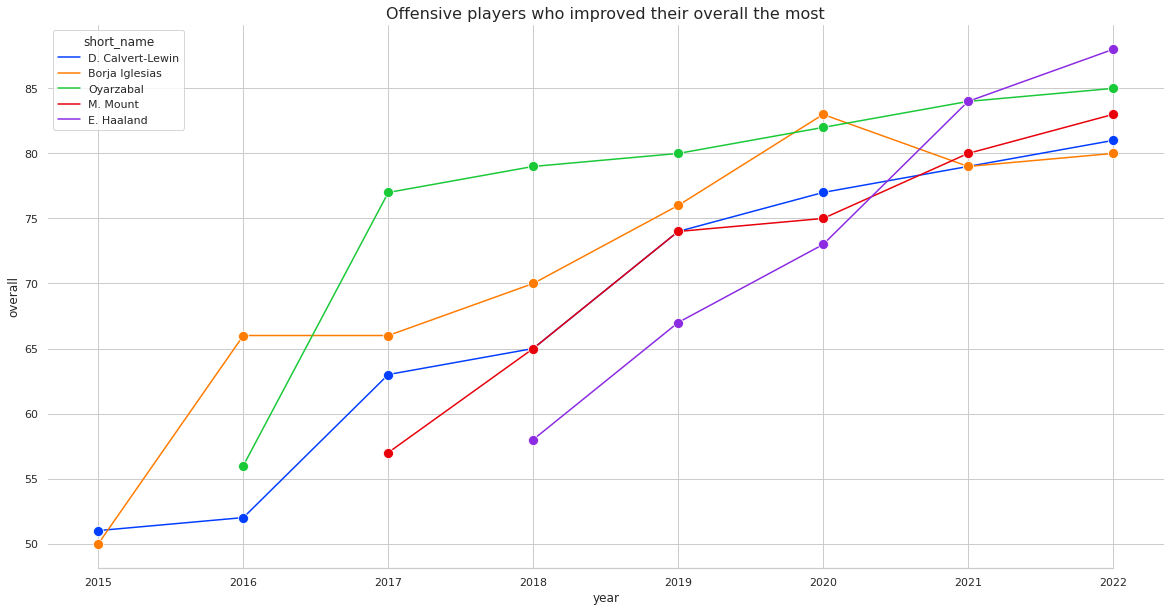

In [125]:
plot_line(data = historical_data, title = 'Offensive players who improved their overall the most', y = 'overall', n = 5)

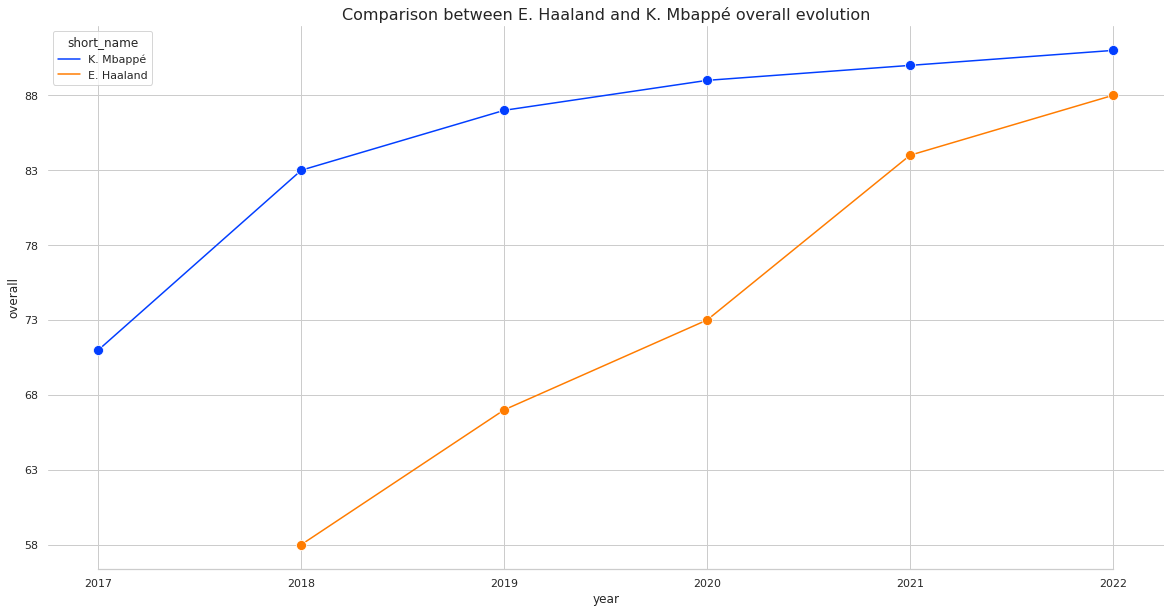

In [126]:
plot_line(data = historical_data, title = "Comparison between E. Haaland and K. Mbappé overall evolution", y='overall', short_name = ['E. Haaland', 'K. Mbappé'])

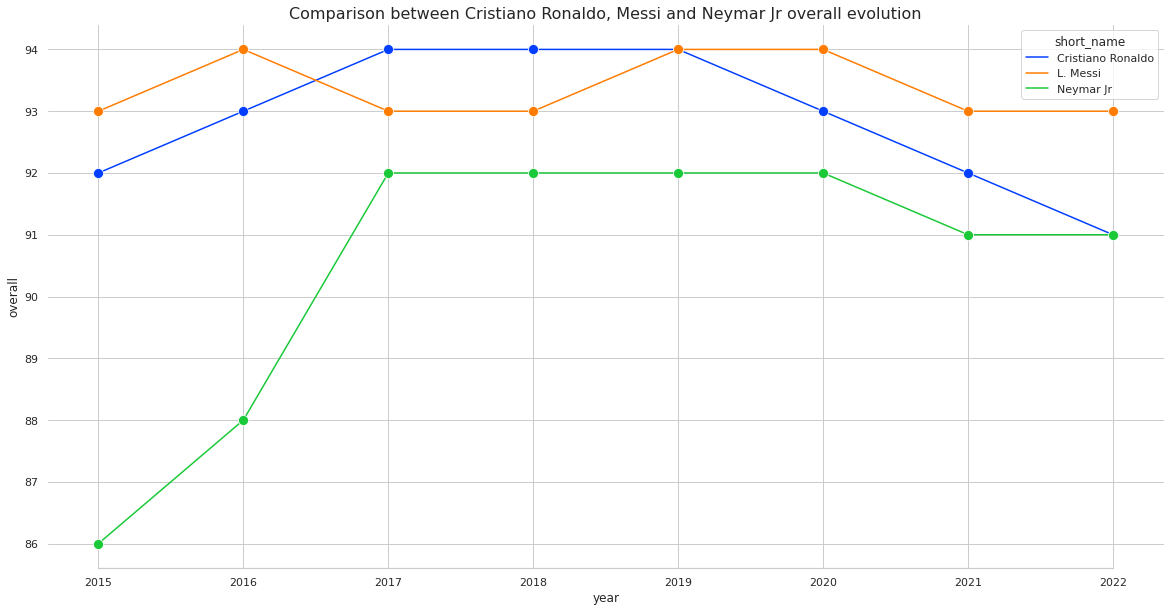

In [127]:
plot_line(data = historical_data, title = "Comparison between Cristiano Ronaldo, Messi and Neymar Jr overall evolution", y='overall', short_name = ['Cristiano Ronaldo', 'L. Messi', 'Neymar Jr'])

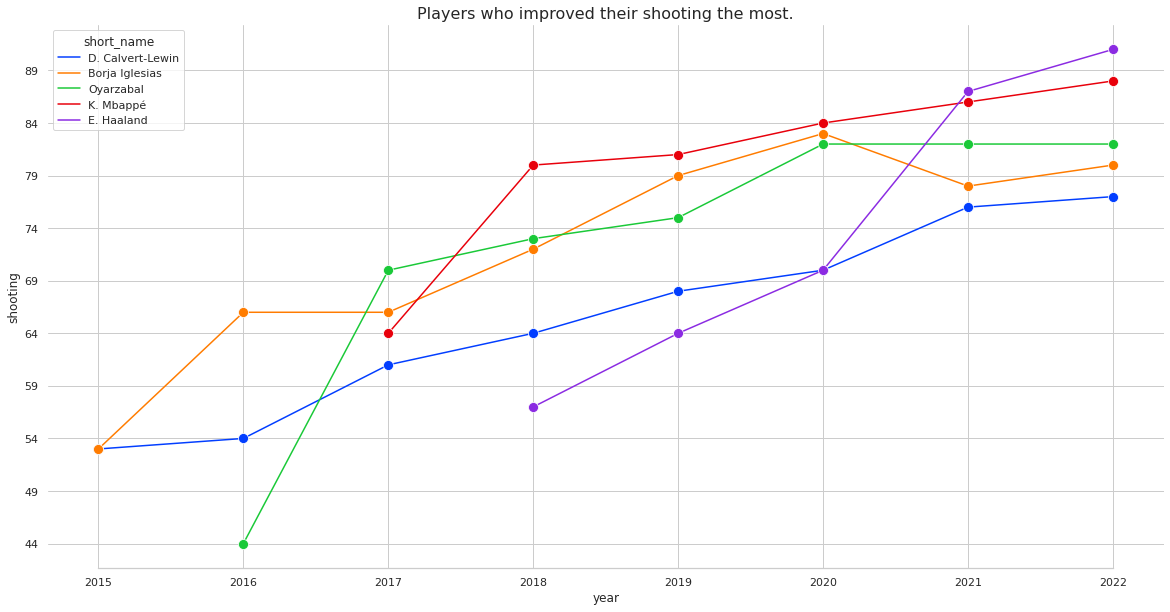

In [128]:
plot_line(data = historical_data, title = "Players who improved their shooting the most.", y='shooting', n = 5)

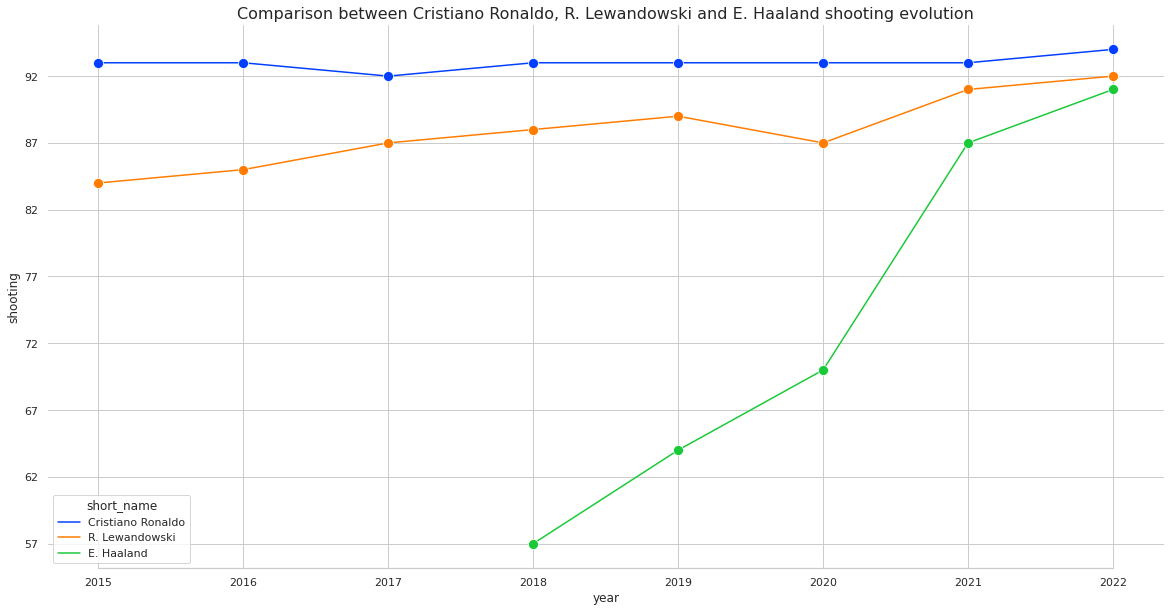

In [129]:
plot_line(data = historical_data, title = "Comparison between Cristiano Ronaldo, R. Lewandowski and E. Haaland shooting evolution", y='shooting', short_name = ['Cristiano Ronaldo'
                                                                                                                                                              , 'E. Haaland'
                                                                                                                                                              , 'R. Lewandowski'])

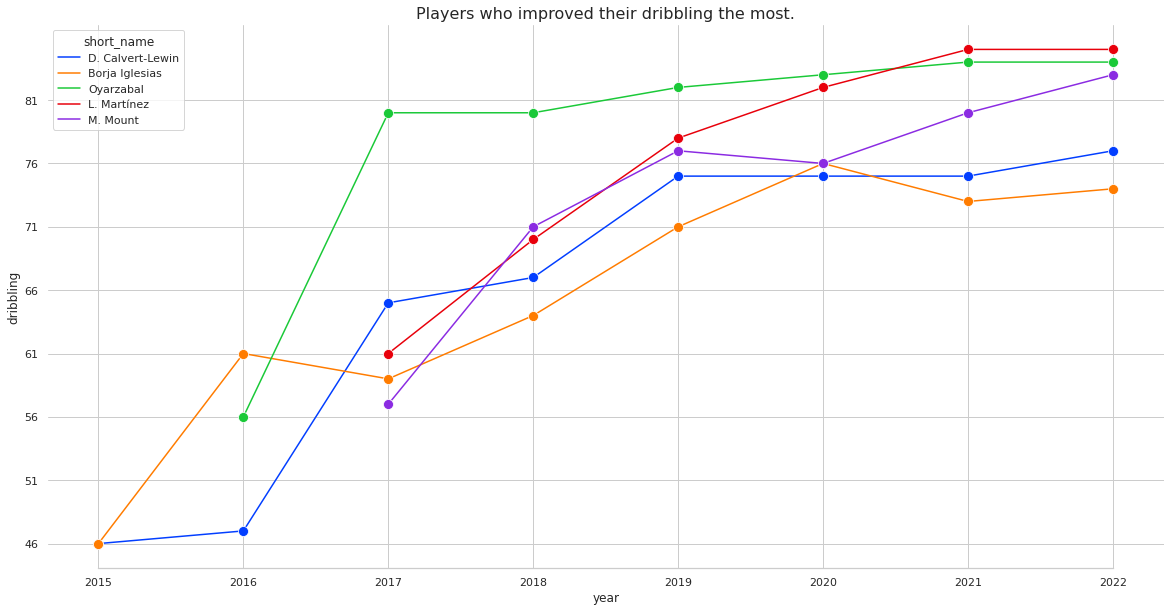

In [130]:
plot_line(data = historical_data, title = "Players who improved their dribbling the most.", y='dribbling', n = 5)

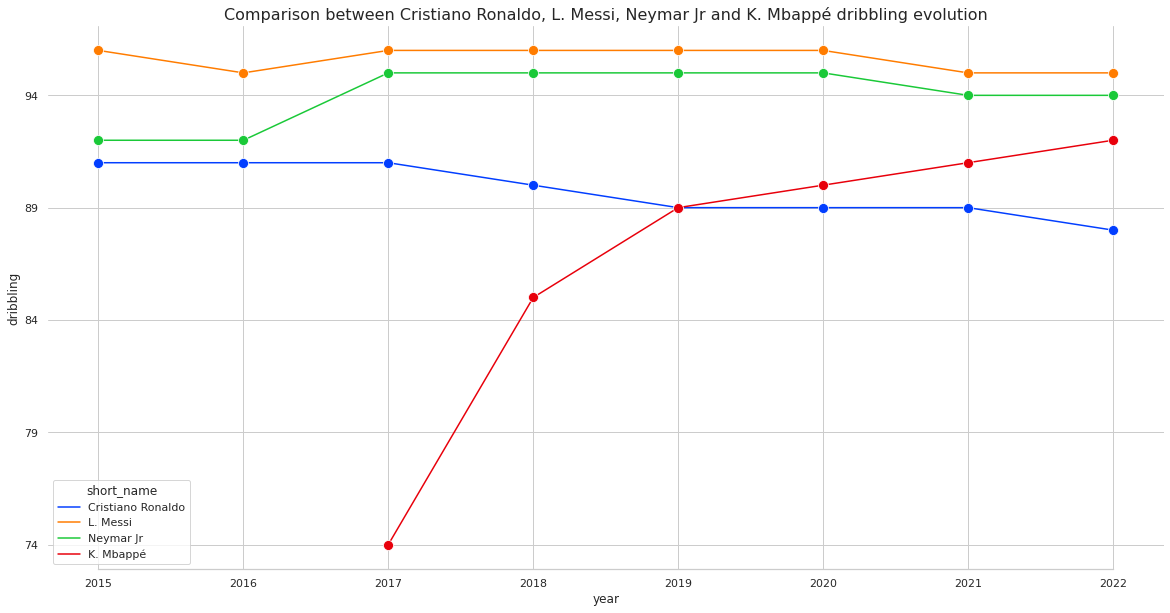

In [131]:
plot_line(data = historical_data, title = "Comparison between Cristiano Ronaldo, L. Messi, Neymar Jr and K. Mbappé dribbling evolution", y='dribbling', short_name = ['Cristiano Ronaldo'
                                                                                                                                                     , 'L. Messi'
                                                                                                                                                     , 'K. Mbappé'
                                                                                                                                                     , 'Neymar Jr'])